In [134]:
# Import necessary libraries
import seisbench
import seisbench.data as sbd
import seisbench.util as sbu

import os
import random
import time
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import obspy
from obspy import read, UTCDateTime

## 1. Dataset Preparation and first glance: 3HZ Highpass Filtering is applied.

In [55]:
# Function 1: Obtain a random stream file from the directory
def get_random_stream_file(directory):
    files = os.listdir(directory)
    chosen_file = None
    count = 0
    for file in files:
        count += 1
        if random.randint(1, count) == 1:
            # The file name 
            chosen_file = os.path.join(directory, file)
    # Return the chosen file
    return obspy.read(chosen_file)


# Function 2: High-pass filter the stream
def apply_highpass(stream, freq, corners=4, zerophase=True):
    """
    Applies a highpass filter to a given Stream.
    :param stream: The Stream to be filtered
    :param freq: The cutoff frequency of the highpass filter
    :param corners: The number of corners of the filter
    :param zerophase: If True, apply zero-phase filtering
    :return: A new Stream with the highpass filter applied
    """
    # Note: don't forget to deepcopy the stream before applying the filter
    filtered_stream = stream.copy()
    filtered_stream.filter('highpass', freq=freq, corners=corners, zerophase=zerophase)
    return filtered_stream

In [105]:
# Function 3-1: Visualize the trace before and after filtering
def visualize_trace_before_filtering(trace_before, filename="trace_before_filtering.png"):
    fig = trace_before.plot(fig=plt.figure(figsize=(10,6)), handel=True)
    ax = fig.axes[0]
    ax.set_title(f"Waveform of the trace {trace_before.stats.channel} before filtering")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    
def visualize_trace_after_filtering(trace_after, freq, filename="trace_after_filtering.png"):
    fig = trace_after.plot(fig=plt.figure(figsize=(10,6)), handel=True)
    ax = fig.axes[0]
    ax.set_title(f"Waveform of the trace {trace_after.stats.channel} after {freq}$HZ$ Highpass filtering")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    
def visualize_spectrogram_before_filtering(trace_before, filename="trace_spectrogram_before_filtering.png"):
    fig, ax = plt.subplots(figsize=(10, 6))
    trace_before.spectrogram(log=True, title="Spectrogram", axes=ax)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_title(f"Spectrogram of the original trace {trace_before.stats.channel}")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    
def visualize_spectrogram_after_filtering(trace_after, freq, filename="trace_spectrogram_after_filtering.png"):
    fig, ax = plt.subplots(figsize=(10, 6))
    trace_after.spectrogram(log=True, title="Spectrogram", axes=ax)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_title(f"Spectrogram of the trace {trace_after.stats.channel} after {freq}$HZ$ Highpass filtering")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

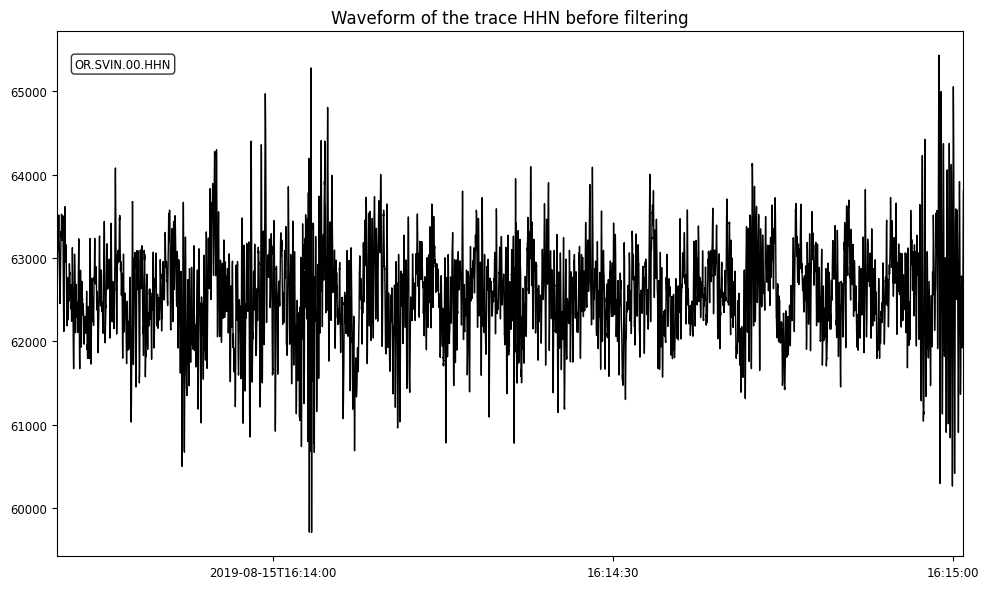

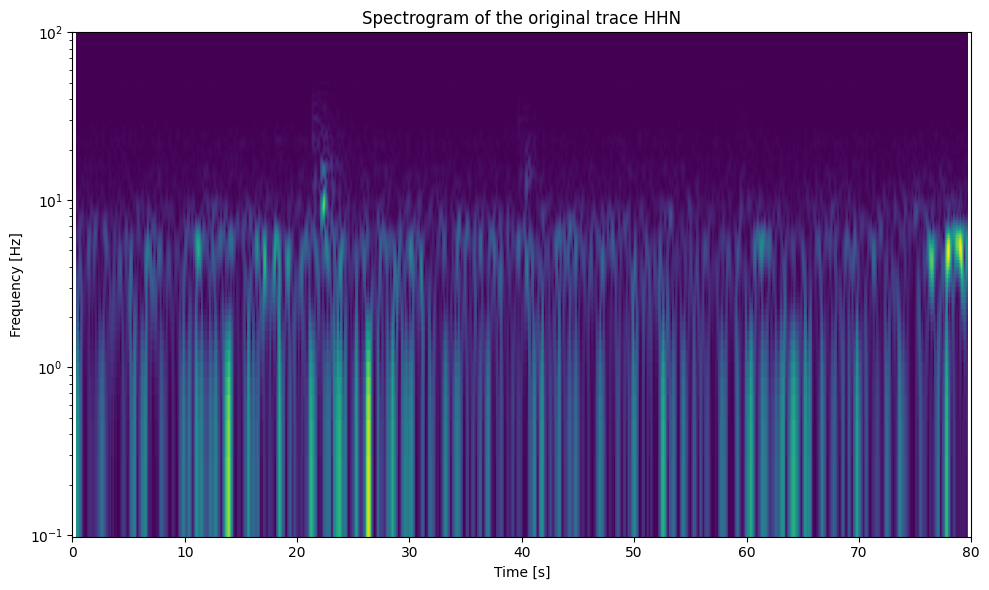

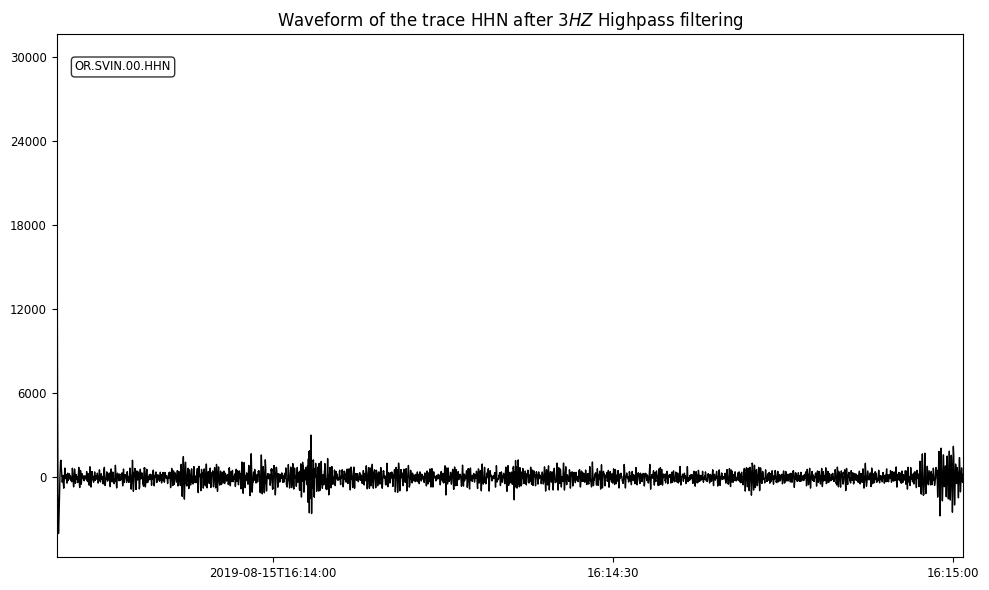

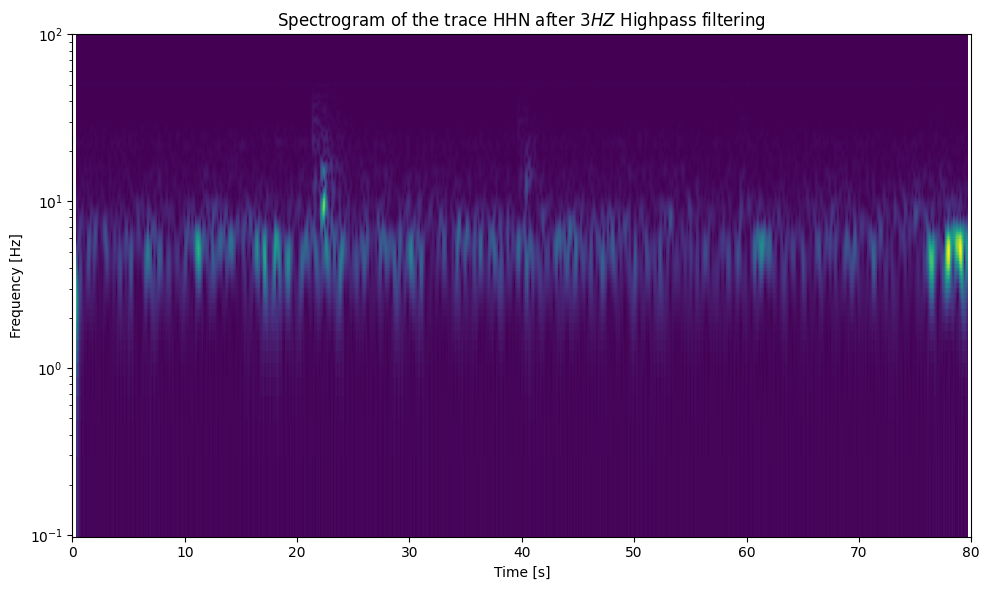

In [164]:
# Load a random stream file before filtering
original_waveform_dir_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic/"
# Original stream v.s. Filtered stream
freq = 3
stream = get_random_stream_file(original_waveform_dir_path)
filtered_stream = apply_highpass(stream, freq=freq)

# 4 Plots for visualization
# 1) before filtering
trace_before = stream[1]
visualize_trace_before_filtering(trace_before=trace_before)
visualize_spectrogram_before_filtering(trace_before=trace_before)
# 2) after filtering
trace_after = filtered_stream[1]
visualize_trace_after_filtering(trace_after=trace_after, freq=freq)
visualize_spectrogram_after_filtering(trace_after=trace_after, freq=freq)

In [140]:
trace_before.stats.mseed.encoding

'STEIM2'

## 2. Generate all waveforms (.mseed) with 3HZ Highpass Filtering

In [135]:
def copy_files_based_on_csv(csv_path, source_dir, target_dir):
    """
    Copy files listed in a CSV file from a source directory to a target directory.
    """
    df = pd.read_csv(csv_path)
    
    # Create the target directory if it does not exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # Loop through the rows of the DataFrame
    count = 0
    for trace_name in df['trace_name']:
        source_file = os.path.join(source_dir, trace_name)
        target_file = os.path.join(target_dir, trace_name)
        
        # Copy the file if it exists
        if os.path.exists(source_file):
            count += 1
            shutil.copy(source_file, target_file)
        else:
            print(f"File not found: {source_file}")
            
    print(f"{count} Files have been copied successfully!")

In [136]:
base_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data"
csv_file_path = os.path.join(base_path, "pick_metadata.csv")
source_directory = os.path.join(base_path, "seismic")                   # All files directory
target_directory = os.path.join(base_path, "seismic_before_filtering")  # Target directory
copy_files_based_on_csv(csv_file_path, source_directory, target_directory)

111836 Files have been copied successfully!


In [141]:
def highpass_and_resave(input_dir, output_dir, freq, corners=4, zerophase=True):
    """
    Apply a highpass filter to each .mseed file in the input directory and save
    the filtered data to the output directory with the same filename.
    """
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created the output directory.")
    
    count = 0   
    # List all .mseed files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.mseed'):
            file_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            
            # Read, filter, and resave the stream
            st = read(file_path)
            st.filter('highpass', freq=freq, corners=corners, zerophase=zerophase)
            st.write(output_path, encoding='STEIM2')
            count += 1
            
    print(f"{count} files have been filtered and resaved successfully!")

In [142]:
original_waveform_dir_path = target_directory
filtered_waveform_dir_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_highpass_3HZ"
freq = 3
highpass_and_resave(input_dir=original_waveform_dir_path, output_dir=filtered_waveform_dir_path, freq=freq)

# Note: after highpass filtering, the data is not integer! which causes the encoding will change to float and the file size will increase.

Created the output directory.


Exception: 
                    Wrong dtype for Stream[0].data for encoding STEIM2.
                    Please change the dtype of your data or use an appropriate
                    encoding. See the obspy.io.mseed documentation for more
                    information.
                    

## 3. Re-process the dataset with 2 groups: 1) Original dataset 2) Dataset with 3HZ Highpass Filtering

### 3.1 Re-validation

In [144]:
# Original files path
original_metadata_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/pick_metadata.csv"
original_waveform_dir_path1 = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_before_filtering/"
original_waveform_dir_path2 = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_highpass_3HZ/"

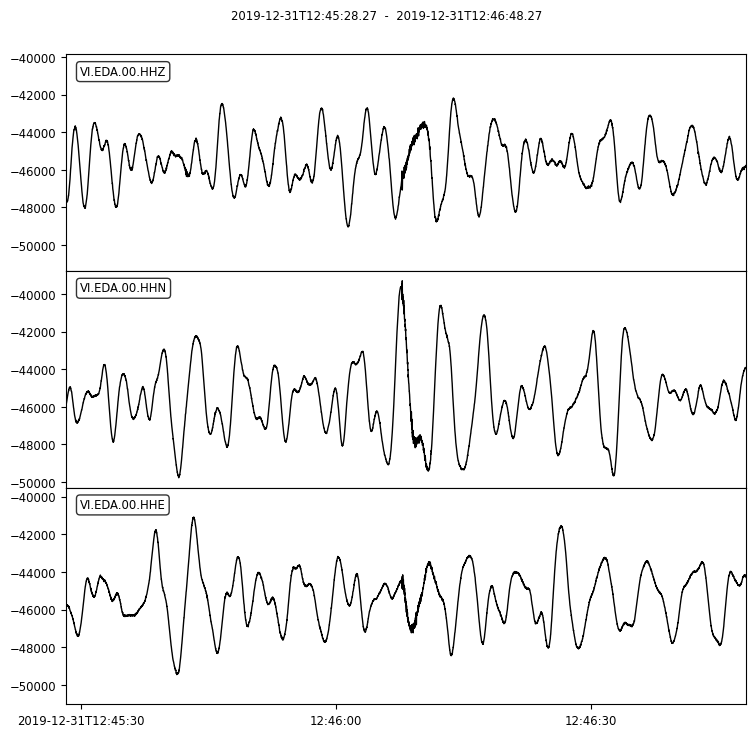

3 Trace(s) in Stream:
VI.EDA.00.HHE | 2019-12-31T12:45:28.270000Z - 2019-12-31T12:46:48.270000Z | 100.0 Hz, 8001 samples
VI.EDA.00.HHN | 2019-12-31T12:45:28.270000Z - 2019-12-31T12:46:48.270000Z | 100.0 Hz, 8001 samples
VI.EDA.00.HHZ | 2019-12-31T12:45:28.270000Z - 2019-12-31T12:46:48.270000Z | 100.0 Hz, 8001 samples


In [154]:
test_file_name = "VI.EDA.00__20191231T124528270000__20191231T124648270000.mseed"
test_waveform_file_name1 = os.path.join(original_waveform_dir_path1, test_file_name)
stream1 = obspy.read(test_waveform_file_name1)
stream1.plot()
print(stream1)

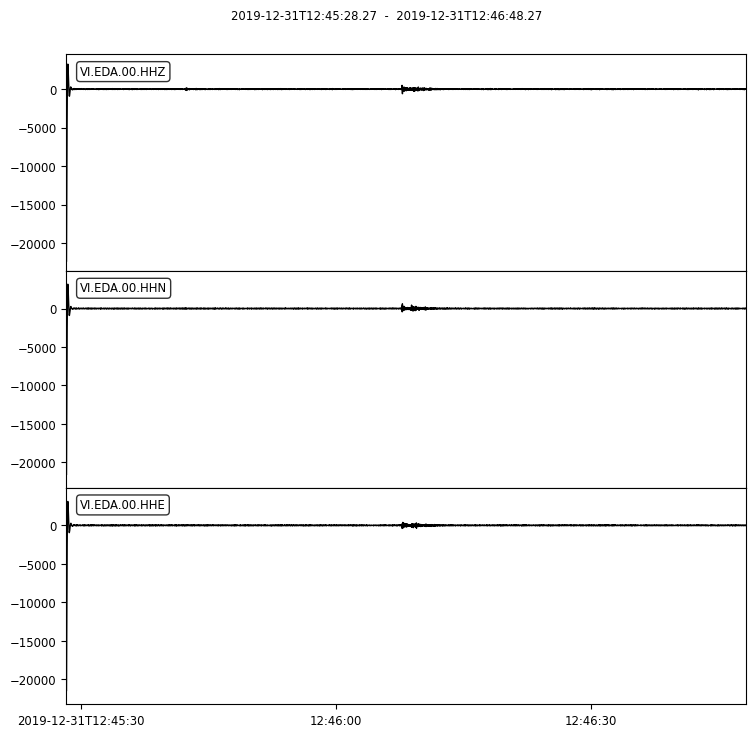

3 Trace(s) in Stream:
VI.EDA.00.HHE | 2019-12-31T12:45:28.270000Z - 2019-12-31T12:46:48.270000Z | 100.0 Hz, 8001 samples
VI.EDA.00.HHN | 2019-12-31T12:45:28.270000Z - 2019-12-31T12:46:48.270000Z | 100.0 Hz, 8001 samples
VI.EDA.00.HHZ | 2019-12-31T12:45:28.270000Z - 2019-12-31T12:46:48.270000Z | 100.0 Hz, 8001 samples


In [155]:
test_waveform_file_name1 = os.path.join(original_waveform_dir_path2, test_file_name)
stream1 = obspy.read(test_waveform_file_name1)
stream1.plot()
print(stream1)

### 3.2 Begin to make the dataset with 2 groups

In [170]:
def save_dataset(metadata, metadata_save_path, dataset_save_path, waveform_dir_path, flag):
    os.makedirs(os.path.dirname(metadata_save_path), exist_ok=True)
    metadata.to_csv(metadata_save_path, index=False)

    with sbd.WaveformDataWriter(metadata_path=metadata_save_path, waveforms_path=dataset_save_path) as writer:
        writer.data_format = {
            "dimension_order": "CW",
            "component_order": "ENZ",  # Here is 'ENZ'! NOt 'ZNE'!
            "measurement": "unknown",
            "unit": "unknown",
            "instrument_response": "restituted",
        }

        for idx, row in metadata.iterrows():
            waveform_path = os.path.join(waveform_dir_path, row["trace_name"])
            if not os.path.exists(waveform_path):
                continue

            waveform = read(waveform_path)
            actual_t_start, data, _ = sbu.stream_to_array(waveform, component_order=writer.data_format["component_order"])

            trace_params = {
                # Note (important): The column name must be the same as the default names shown on the Seisbench documentation!!!
                # You can't use your custom names here! No error will be raised, but the functions (augmentations) will not work properly!!!
                "trace_sampling_rate_hz": waveform[0].stats.sampling_rate,
                "trace_start_time": actual_t_start,
                "trace_p_arrival_sample": int((UTCDateTime(row['p_arrival']) - actual_t_start) * waveform[0].stats.sampling_rate),
                "trace_s_arrival_sample": int((UTCDateTime(row['s_arrival']) - actual_t_start) * waveform[0].stats.sampling_rate),
                "station_code": row["station_code"],
                "source_id": row["source_id"],
                "source_magnitude": row["source_magnitude"],
                "source_magnitude_type": row["source_magnitude_type"],
                "trace_name": row["trace_name"]
            }

            writer.add_trace(trace_params, data)
        
    print(f"{flag} Dataset is saved successfully!")

In [171]:
# 1) original data path:
original_metadata_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/pick_metadata.csv"
original_waveform_dir_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_before_filtering/"
original_waveform_dir_path_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_highpass_3HZ/"

# 2) Read the .csv and split the dataset into 3 parts: train, val, test
original_metadata = pd.read_csv(original_metadata_path) 
train_meta, temp_meta = train_test_split(original_metadata, test_size=0.2, random_state=42)
val_meta, test_meta = train_test_split(temp_meta, test_size=0.5, random_state=42)

In [172]:
# 1) Group 1: before filtering
dataset_base_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/before_filtering"
# 1.1) Train dataset: metadata and waveforms
train_metadata_save_path_before = os.path.join(dataset_base_path_before, "train_dataset/metadata.csv")
train_dataset_save_path_before = os.path.join(dataset_base_path_before, "train_dataset/waveforms.hdf5")
# 2) Validation dataset: metadata and waveforms
val_metadata_save_path_before = os.path.join(dataset_base_path_before, "val_dataset/metadata.csv")
val_dataset_save_path_before = os.path.join(dataset_base_path_before, "val_dataset/waveforms.hdf5")
# 3) Test dataset: metadata and waveforms
test_metadata_save_path_before = os.path.join(dataset_base_path_before, "test_dataset/metadata.csv")
test_dataset_save_path_before = os.path.join(dataset_base_path_before, "test_dataset/waveforms.hdf5")

# 2) Group 2: after 3HZ highpass filtering
dataset_base_path_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/after_filtering"
# 1.1) Train dataset: metadata and waveforms
train_metadata_save_path_after = os.path.join(dataset_base_path_after, "train_dataset/metadata.csv")
train_dataset_save_path_after = os.path.join(dataset_base_path_after, "train_dataset/waveforms.hdf5")
# 2) Validation dataset: metadata and waveforms
val_metadata_save_path_after = os.path.join(dataset_base_path_after, "val_dataset/metadata.csv")
val_dataset_save_path_after = os.path.join(dataset_base_path_after, "val_dataset/waveforms.hdf5")
# 3) Test dataset: metadata and waveforms
test_metadata_save_path_after = os.path.join(dataset_base_path_after, "test_dataset/metadata.csv")
test_dataset_save_path_after = os.path.join(dataset_base_path_after, "test_dataset/waveforms.hdf5")

In [173]:
# 1) Group 1: call the function to save the dataset
save_dataset(train_meta, train_metadata_save_path_before, train_dataset_save_path_before, original_waveform_dir_path_before, flag="Train")
save_dataset(val_meta, val_metadata_save_path_before, val_dataset_save_path_before, original_waveform_dir_path_before, flag="Validation")   
save_dataset(test_meta, test_metadata_save_path_before, test_dataset_save_path_before, original_waveform_dir_path_before, flag="Test")

# 2) Group 2: call the function to save the dataset
save_dataset(train_meta, train_metadata_save_path_after, train_dataset_save_path_after, original_waveform_dir_path_after, flag="Train")
save_dataset(val_meta, val_metadata_save_path_after, val_dataset_save_path_after, original_waveform_dir_path_after, flag="Validation")
save_dataset(test_meta, test_metadata_save_path_after, test_dataset_save_path_after, original_waveform_dir_path_after, flag="Test")

Traces converted: 89468it [04:28, 333.41it/s]


Train Dataset is saved successfully!


Traces converted: 11184it [00:42, 261.59it/s]


Validation Dataset is saved successfully!


Traces converted: 11184it [00:43, 257.85it/s]


Test Dataset is saved successfully!


Traces converted: 89468it [08:36, 173.20it/s]


Train Dataset is saved successfully!


Traces converted: 11184it [01:04, 173.87it/s]


Validation Dataset is saved successfully!


Traces converted: 11184it [01:04, 173.97it/s]

Test Dataset is saved successfully!


### 3.3 Check the information of the dataset

#### 3.3.1 Group 1: before filtering

In [174]:
train_dataset_base_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/before_filtering/train_dataset/"
val_dataset_base_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/before_filtering/val_dataset/"
test_dataset_base_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/before_filtering/test_dataset/"
# Load the .h5 files
train_dataset_before = sbd.WaveformDataset(train_dataset_base_path_before, component_order="ENZ")
val_dataset_before = sbd.WaveformDataset(val_dataset_base_path_before, component_order="ENZ")
test_dataset_before = sbd.WaveformDataset(test_dataset_base_path_before, component_order="ENZ")
print("Total samples: ", len(train_dataset_before) + len(val_dataset_before) + len(test_dataset_before))

2024-06-01 21:24:57,709 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-06-01 21:24:57,859 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-06-01 21:24:57,909 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.


Total samples:  111836


In [175]:
train_dataset_before.metadata

,index,trace_sampling_rate_hz,trace_start_time,trace_p_arrival_sample,trace_s_arrival_sample,station_code,source_id,source_magnitude,source_magnitude_type,trace_name,trace_name_original,trace_chunk,trace_component_order
0,0,200.0,2020-02-09T07:29:53.430000Z,7892,8107,2C.GAN02..HH,smi:org.gfz-potsdam.de/geofon/isor2020cuegny,0.328192,ML,"bucket0$0,:3,:16001",2C.GAN02.__20200209T072953430000__20200209T073...,,ENZ
1,1,200.0,2020-01-04T05:22:19.515000Z,7856,8143,2C.JAK25..EH,smi:org.gfz-potsdam.de/geofon/isor2020afxwsa,0.185662,ML,"bucket0$1,:3,:16001",2C.JAK25.__20200104T052219515000__20200104T052...,,ENZ
2,2,100.0,2020-05-18T01:19:10.710000Z,3907,4091,VI.SAN..HH,smi:org.gfz-potsdam.de/geofon/isor2020jtkwfe,1.557447,ML,"bucket8$0,:3,:8001",VI.SAN.00__20200518T011910710000__20200518T012...,,ENZ
3,3,200.0,2019-07-30T09:10:41.405000Z,7883,8115,VE.GELDA..HH,smi:org.gfz-potsdam.de/geofon/isor2019owetwz,-0.035276,ML,"bucket0$2,:3,:16001",VE.GELDA.00__20190730T091041405000__20190730T0...,,ENZ
4,4,100.0,2019-08-06T06:30:08.250000Z,3889,4109,VI.EDA..HH,smi:org.gfz-potsdam.de/geofon/isor2019pivnry,0.253366,ML,"bucket8$1,:3,:8001",VI.EDA.00__20190806T063008250000__20190806T063...,,ENZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89463,89463,200.0,2020-09-11T07:11:12.745000Z,7910,8088,2C.GAN02..HH,smi:org.gfz-potsdam.de/geofon/isor2020ryutov,0.139212,ML,"bucket86$679,:3,:16001",2C.GAN02.__20200911T071112745000__20200911T071...,,ENZ
89464,89464,200.0,2020-01-11T00:46:55.800000Z,7798,8201,2C.OHO23..EH,smi:org.gfz-potsdam.de/geofon/isor2020askvuh,0.805901,ML,"bucket86$680,:3,:16001",2C.OHO23.__20200111T004655800000__20200111T004...,,ENZ
89465,89465,200.0,2020-02-11T23:27:22.420000Z,7898,8102,2C.BIT06..HH,smi:org.gfz-potsdam.de/geofon/isor2020czblkh,0.248548,ML,"bucket86$681,:3,:16001",2C.BIT06.__20200211T232722420000__20200211T232...,,ENZ
89466,89466,200.0,2019-12-22T19:04:52.015000Z,7921,8079,2C.SKA10..HH,smi:org.gfz-potsdam.de/geofon/isor2019zdctoe,0.173443,ML,"bucket86$682,:3,:16001",2C.SKA10.__20191222T190452015000__20191222T190...,,ENZ


In [176]:
val_dataset_before.metadata

,index,trace_sampling_rate_hz,trace_start_time,trace_p_arrival_sample,trace_s_arrival_sample,station_code,source_id,source_magnitude,source_magnitude_type,trace_name,trace_name_original,trace_chunk,trace_component_order
0,0,200.0,2020-10-21T13:05:40.825000Z,7891,8108,2C.OLK26..EH,smi:org.gfz-potsdam.de/geofon/isor2020uuroii,0.408661,ML,"bucket0$0,:3,:16001",2C.OLK26.__20201021T130540825000__20201021T130...,,ENZ
1,1,200.0,2019-07-31T06:34:24.577400Z,7905,8094,OR.LSKAR..HH,smi:org.gfz-potsdam.de/geofon/isor2019oxvidd,0.161607,ML,"bucket0$1,:3,:16001",OR.LSKAR.00__20190731T063424577400__20190731T0...,,ENZ
2,2,200.0,2020-11-11T03:19:38.795000Z,7852,8147,2C.OLK26..EH,smi:org.gfz-potsdam.de/geofon/isor2020wgmjvf,0.577061,ML,"bucket0$2,:3,:16001",2C.OLK26.__20201111T031938795000__20201111T032...,,ENZ
3,3,200.0,2020-01-11T21:59:16.157000Z,7801,8197,OR.LSKAR..HH,smi:org.gfz-potsdam.de/geofon/isor2020aubaey,0.666348,ML,"bucket0$3,:3,:16001",OR.LSKAR.00__20200111T215916157000__20200111T2...,,ENZ
4,4,200.0,2020-10-20T17:35:39.475000Z,7916,8084,2C.SKA10..HH,smi:org.gfz-potsdam.de/geofon/isor2020uteucq,0.340757,ML,"bucket0$4,:3,:16001",2C.SKA10.__20201020T173539475000__20201020T173...,,ENZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11179,11179,200.0,2020-09-18T06:28:05.575000Z,7886,8112,2C.OLK26..EH,smi:org.gfz-potsdam.de/geofon/isor2020slpkrl,0.386267,ML,"bucket10$805,:3,:16001",2C.OLK26.__20200918T062805575000__20200918T062...,,ENZ
11180,11180,200.0,2020-04-09T08:40:12.530000Z,7943,8056,2C.OLK26..EH,smi:org.gfz-potsdam.de/geofon/isor2020hakdzc,0.184033,ML,"bucket10$806,:3,:16001",2C.OLK26.__20200409T084012530000__20200409T084...,,ENZ
11181,11181,100.0,2019-03-18T22:03:54.460000Z,3885,4114,VI.HEI..HH,smi:org.gfz-potsdam.de/geofon/isor2019flfcgg,1.054396,ML,"bucket11$132,:3,:8001",VI.HEI.00__20190318T220354460000__20190318T220...,,ENZ
11182,11182,200.0,2020-10-05T09:56:38.987400Z,7830,8169,OR.HVH..HH,smi:org.gfz-potsdam.de/geofon/isor2020trbrid,0.234973,ML,"bucket10$807,:3,:16001",OR.HVH.00__20201005T095638987400__20201005T095...,,ENZ


In [177]:
test_dataset_before.metadata

,index,trace_sampling_rate_hz,trace_start_time,trace_p_arrival_sample,trace_s_arrival_sample,station_code,source_id,source_magnitude,source_magnitude_type,trace_name,trace_name_original,trace_chunk,trace_component_order
0,0,200.0,2019-02-03T21:35:23.900000Z,7907,8092,2C.GAN02..HH,smi:org.gfz-potsdam.de/geofon/isor2019ckfxwo,0.502666,ML,"bucket0$0,:3,:16001",2C.GAN02.__20190203T213523900000__20190203T213...,,ENZ
1,1,200.0,2019-01-06T16:58:56.299900Z,7910,8088,OR.KOLDU..HH,smi:org.gfz-potsdam.de/geofon/isor2019akmkvu,0.368410,ML,"bucket0$1,:3,:16001",OR.KOLDU.00__20190106T165856299900__20190106T1...,,ENZ
2,2,200.0,2019-07-03T20:32:34.825000Z,7914,8086,OR.INNST..HH,smi:org.gfz-potsdam.de/geofon/isor2019mzmttg,0.093927,ML,"bucket0$2,:3,:16001",OR.INNST.00__20190703T203234825000__20190703T2...,,ENZ
3,3,200.0,2019-05-24T16:40:55.945000Z,7896,8103,2C.THU04..HH,smi:org.gfz-potsdam.de/geofon/isor2019kduayb,0.187469,ML,"bucket0$3,:3,:16001",2C.THU04.__20190524T164055945000__20190524T164...,,ENZ
4,4,200.0,2019-11-05T03:41:12.390000Z,7776,8222,2C.GAN02..HH,smi:org.gfz-potsdam.de/geofon/isor2019vtrafk,0.364035,ML,"bucket0$4,:3,:16001",2C.GAN02.__20191105T034112390000__20191105T034...,,ENZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11179,11179,200.0,2019-08-04T12:20:46.005000Z,7867,8133,2C.MEI05..HH,smi:org.gfz-potsdam.de/geofon/isor2019pfprxq,-0.063777,ML,"bucket10$823,:3,:16001",2C.MEI05.__20190804T122046005000__20190804T122...,,ENZ
11180,11180,200.0,2020-02-29T00:04:26.730000Z,7806,8194,OR.LSKAR..HH,smi:org.gfz-potsdam.de/geofon/isor2020eeiahi,0.421205,ML,"bucket10$824,:3,:16001",OR.LSKAR.00__20200229T000426730000__20200229T0...,,ENZ
11181,11181,200.0,2020-09-05T06:56:34.430000Z,7960,8039,OR.HUMLI..HH,smi:org.gfz-potsdam.de/geofon/isor2020rntxva,-0.319277,ML,"bucket10$825,:3,:16001",OR.HUMLI.00__20200905T065634430000__20200905T0...,,ENZ
11182,11182,200.0,2020-10-01T11:47:44.325000Z,7865,8134,OR.SVIN..HH,smi:org.gfz-potsdam.de/geofon/isor2020tjwlki,0.995589,ML,"bucket10$826,:3,:16001",OR.SVIN.00__20201001T114744325000__20201001T11...,,ENZ


In [401]:
test_dataset_before[0]

TypeError: Can only use strings to access metadata parameters

In [396]:
test_dataset_before.metadata.iloc[0]

index                                                                     0
trace_sampling_rate_hz                                                200.0
trace_start_time                                2019-02-03T21:35:23.900000Z
trace_p_arrival_sample                                                 7907
trace_s_arrival_sample                                                 8092
station_code                                                   2C.GAN02..HH
source_id                      smi:org.gfz-potsdam.de/geofon/isor2019ckfxwo
source_magnitude                                                   0.502666
source_magnitude_type                                                    ML
trace_name                                              bucket0$0,:3,:16001
trace_name_original       2C.GAN02.__20190203T213523900000__20190203T213...
trace_chunk                                                                
trace_component_order                                                   ENZ
Name: 0, dty

#### 3.3.2 Group 2: after filtering

In [178]:
train_dataset_base_path_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/after_filtering/train_dataset/"
val_dataset_base_path_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/after_filtering/val_dataset/"
test_dataset_base_path_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/after_filtering/test_dataset/"
# Load the .h5 files
train_dataset_after = sbd.WaveformDataset(train_dataset_base_path_after, component_order="ENZ")
val_dataset_after = sbd.WaveformDataset(val_dataset_base_path_after, component_order="ENZ")
test_dataset_after = sbd.WaveformDataset(test_dataset_base_path_after, component_order="ENZ")
print("Total samples: ", len(train_dataset_after) + len(val_dataset_after) + len(test_dataset_after))

2024-06-01 21:25:17,638 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-06-01 21:25:17,774 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-06-01 21:25:17,826 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.


Total samples:  111836


In [179]:
train_dataset_after.metadata

,index,trace_sampling_rate_hz,trace_start_time,trace_p_arrival_sample,trace_s_arrival_sample,station_code,source_id,source_magnitude,source_magnitude_type,trace_name,trace_name_original,trace_chunk,trace_component_order
0,0,200.0,2020-02-09T07:29:53.430000Z,7892,8107,2C.GAN02..HH,smi:org.gfz-potsdam.de/geofon/isor2020cuegny,0.328192,ML,"bucket0$0,:3,:16001",2C.GAN02.__20200209T072953430000__20200209T073...,,ENZ
1,1,200.0,2020-01-04T05:22:19.515000Z,7856,8143,2C.JAK25..EH,smi:org.gfz-potsdam.de/geofon/isor2020afxwsa,0.185662,ML,"bucket0$1,:3,:16001",2C.JAK25.__20200104T052219515000__20200104T052...,,ENZ
2,2,100.0,2020-05-18T01:19:10.710000Z,3907,4091,VI.SAN..HH,smi:org.gfz-potsdam.de/geofon/isor2020jtkwfe,1.557447,ML,"bucket8$0,:3,:8001",VI.SAN.00__20200518T011910710000__20200518T012...,,ENZ
3,3,200.0,2019-07-30T09:10:41.405000Z,7883,8115,VE.GELDA..HH,smi:org.gfz-potsdam.de/geofon/isor2019owetwz,-0.035276,ML,"bucket0$2,:3,:16001",VE.GELDA.00__20190730T091041405000__20190730T0...,,ENZ
4,4,100.0,2019-08-06T06:30:08.250000Z,3889,4109,VI.EDA..HH,smi:org.gfz-potsdam.de/geofon/isor2019pivnry,0.253366,ML,"bucket8$1,:3,:8001",VI.EDA.00__20190806T063008250000__20190806T063...,,ENZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89463,89463,200.0,2020-09-11T07:11:12.745000Z,7910,8088,2C.GAN02..HH,smi:org.gfz-potsdam.de/geofon/isor2020ryutov,0.139212,ML,"bucket86$679,:3,:16001",2C.GAN02.__20200911T071112745000__20200911T071...,,ENZ
89464,89464,200.0,2020-01-11T00:46:55.800000Z,7798,8201,2C.OHO23..EH,smi:org.gfz-potsdam.de/geofon/isor2020askvuh,0.805901,ML,"bucket86$680,:3,:16001",2C.OHO23.__20200111T004655800000__20200111T004...,,ENZ
89465,89465,200.0,2020-02-11T23:27:22.420000Z,7898,8102,2C.BIT06..HH,smi:org.gfz-potsdam.de/geofon/isor2020czblkh,0.248548,ML,"bucket86$681,:3,:16001",2C.BIT06.__20200211T232722420000__20200211T232...,,ENZ
89466,89466,200.0,2019-12-22T19:04:52.015000Z,7921,8079,2C.SKA10..HH,smi:org.gfz-potsdam.de/geofon/isor2019zdctoe,0.173443,ML,"bucket86$682,:3,:16001",2C.SKA10.__20191222T190452015000__20191222T190...,,ENZ


In [180]:
val_dataset_after.metadata

,index,trace_sampling_rate_hz,trace_start_time,trace_p_arrival_sample,trace_s_arrival_sample,station_code,source_id,source_magnitude,source_magnitude_type,trace_name,trace_name_original,trace_chunk,trace_component_order
0,0,200.0,2020-10-21T13:05:40.825000Z,7891,8108,2C.OLK26..EH,smi:org.gfz-potsdam.de/geofon/isor2020uuroii,0.408661,ML,"bucket0$0,:3,:16001",2C.OLK26.__20201021T130540825000__20201021T130...,,ENZ
1,1,200.0,2019-07-31T06:34:24.577400Z,7905,8094,OR.LSKAR..HH,smi:org.gfz-potsdam.de/geofon/isor2019oxvidd,0.161607,ML,"bucket0$1,:3,:16001",OR.LSKAR.00__20190731T063424577400__20190731T0...,,ENZ
2,2,200.0,2020-11-11T03:19:38.795000Z,7852,8147,2C.OLK26..EH,smi:org.gfz-potsdam.de/geofon/isor2020wgmjvf,0.577061,ML,"bucket0$2,:3,:16001",2C.OLK26.__20201111T031938795000__20201111T032...,,ENZ
3,3,200.0,2020-01-11T21:59:16.157000Z,7801,8197,OR.LSKAR..HH,smi:org.gfz-potsdam.de/geofon/isor2020aubaey,0.666348,ML,"bucket0$3,:3,:16001",OR.LSKAR.00__20200111T215916157000__20200111T2...,,ENZ
4,4,200.0,2020-10-20T17:35:39.475000Z,7916,8084,2C.SKA10..HH,smi:org.gfz-potsdam.de/geofon/isor2020uteucq,0.340757,ML,"bucket0$4,:3,:16001",2C.SKA10.__20201020T173539475000__20201020T173...,,ENZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11179,11179,200.0,2020-09-18T06:28:05.575000Z,7886,8112,2C.OLK26..EH,smi:org.gfz-potsdam.de/geofon/isor2020slpkrl,0.386267,ML,"bucket10$805,:3,:16001",2C.OLK26.__20200918T062805575000__20200918T062...,,ENZ
11180,11180,200.0,2020-04-09T08:40:12.530000Z,7943,8056,2C.OLK26..EH,smi:org.gfz-potsdam.de/geofon/isor2020hakdzc,0.184033,ML,"bucket10$806,:3,:16001",2C.OLK26.__20200409T084012530000__20200409T084...,,ENZ
11181,11181,100.0,2019-03-18T22:03:54.460000Z,3885,4114,VI.HEI..HH,smi:org.gfz-potsdam.de/geofon/isor2019flfcgg,1.054396,ML,"bucket11$132,:3,:8001",VI.HEI.00__20190318T220354460000__20190318T220...,,ENZ
11182,11182,200.0,2020-10-05T09:56:38.987400Z,7830,8169,OR.HVH..HH,smi:org.gfz-potsdam.de/geofon/isor2020trbrid,0.234973,ML,"bucket10$807,:3,:16001",OR.HVH.00__20201005T095638987400__20201005T095...,,ENZ


In [357]:
# How to convert the sample index to the real time of the picking
sample1 = test_dataset_after.metadata['trace_p_arrival_sample'][0]
rate1 = test_dataset_after.metadata['trace_sampling_rate_hz'][0]
start1_time = UTCDateTime(test_dataset_after.metadata['trace_start_time'][0])
time1 = sample1 / rate1
# Convert to time
pick1_time = start1_time + time1
print(pick1_time)

2019-02-03T21:36:03.435000Z


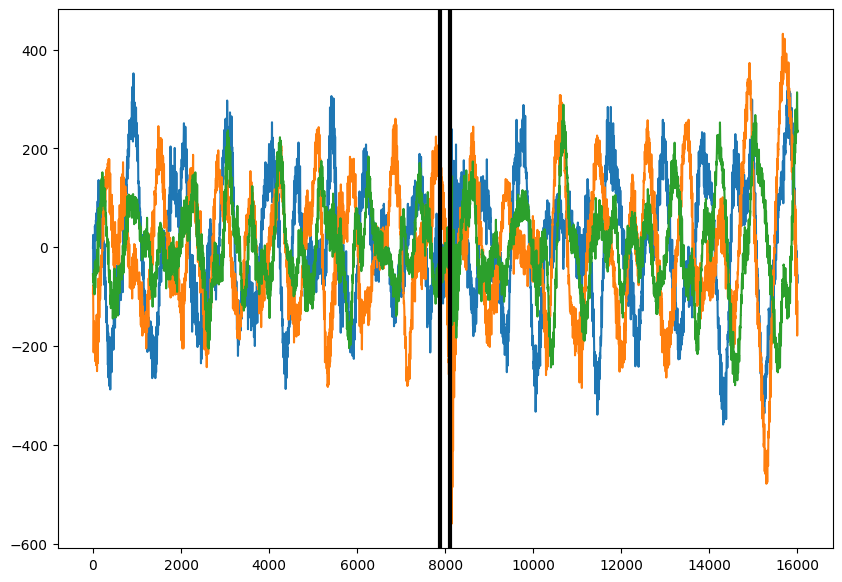

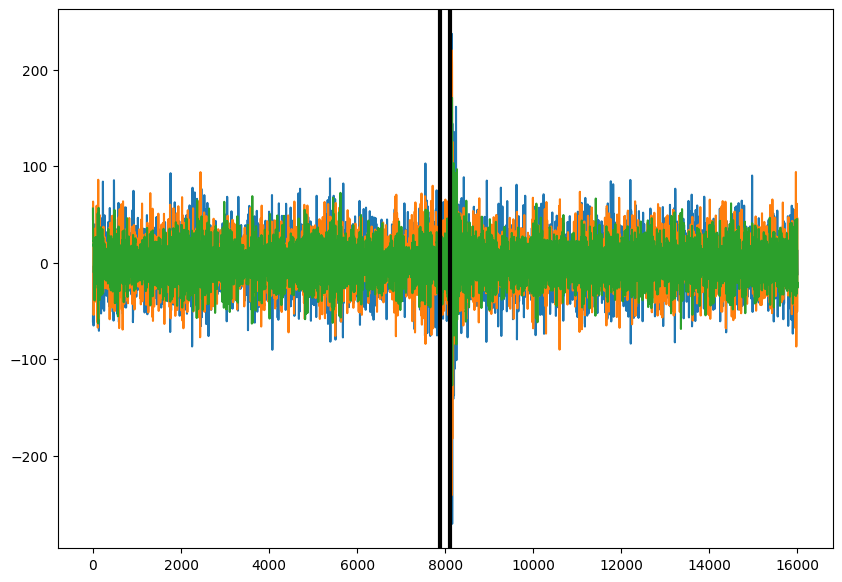

In [184]:
# Plot the first waveform with P and S arrival times (sample index)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(train_dataset_before.get_waveforms(2679).T)
ax.axvline(train_dataset_before.metadata["trace_p_arrival_sample"].iloc[0], color="k", lw=3)
ax.axvline(train_dataset_before.metadata["trace_s_arrival_sample"].iloc[0], color="k", lw=3)

# Plot the first waveform with P and S arrival times (sample index)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(train_dataset_after.get_waveforms(2679).T)
ax.axvline(train_dataset_after.metadata["trace_p_arrival_sample"].iloc[0], color="k", lw=3)
ax.axvline(train_dataset_after.metadata["trace_s_arrival_sample"].iloc[0], color="k", lw=3)

## 4. Dataset Augmentation

In [188]:
import numpy as np
import torch
from torch.utils.data import DataLoader

import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

In [186]:
# Selected from the columns of the metadata: we only have 2 labels
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_s_arrival_sample": "S"
}

#### 4.1 Group 1 (before filtering): Augmentation and Generation 

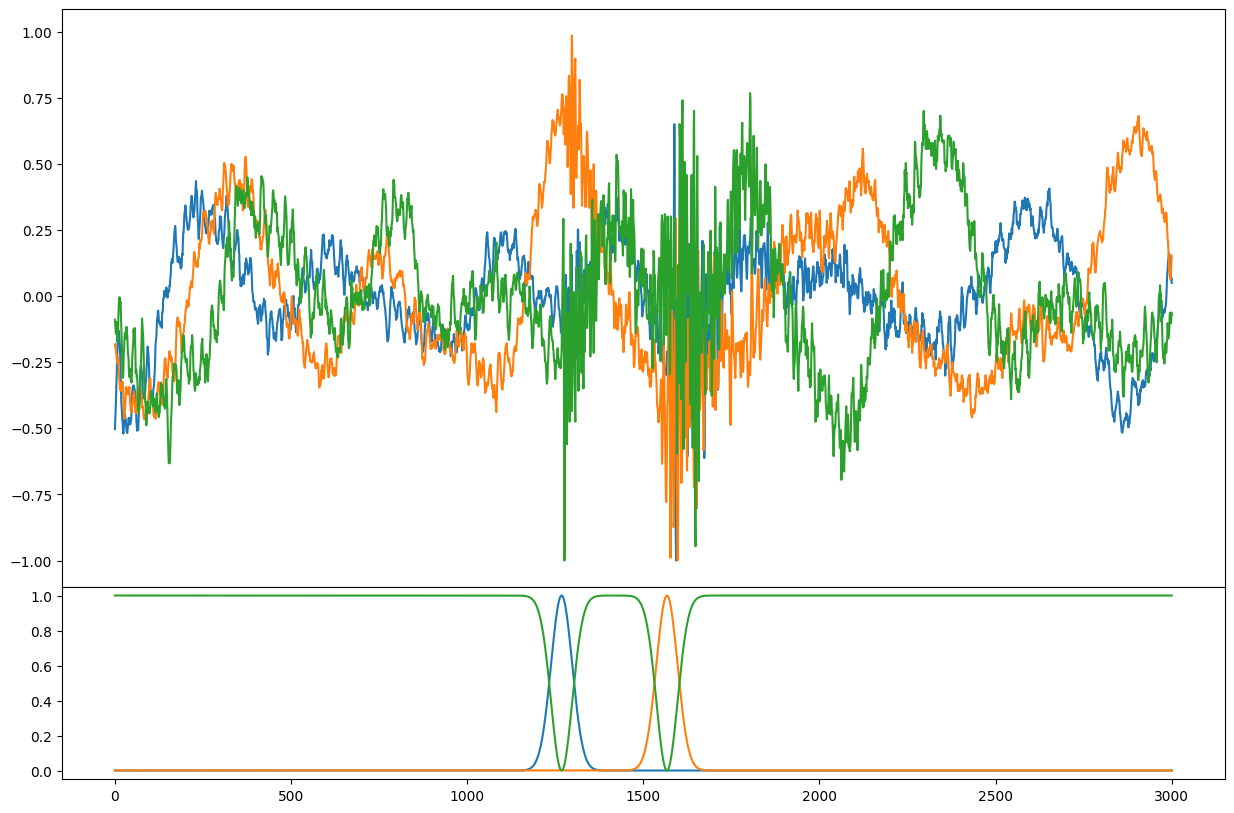

In [199]:
train_generator_before = sbg.GenericGenerator(train_dataset_before)
val_generator_before = sbg.GenericGenerator(val_dataset_before)
test_generator_before = sbg.GenericGenerator(test_dataset_before)

# Note: The windowlen must be larger than 3000 for the PhaseNet model !!!
samples_before = 3000  # 0.1s
windowlen = 6000

# Define the augmentations
augmentations = [
    # First, slice the data roughly around the picks
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=samples_before, windowlen=windowlen, 
                           selection="random", strategy="variable"),
    # Secondly, slide to get several 3001 samples (overlapping is normal), which are the real input data (length)!
    # That's the length of the below images. This is a necessary step which can generate more data.
    sbg.RandomWindow(windowlen=3001, strategy="pad"),  
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

# Add the augmentations to the generators
train_generator_before.add_augmentations(augmentations)
val_generator_before.add_augmentations(augmentations)
test_generator_before.add_augmentations(augmentations)

# Visualize the augmentations
# Note for the 'y' plot which are related to labels: P, S, Noise (1-P-S) 
# Blue: P, Orange: S, Green: Noise
sample_before = train_generator_before[752]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample_before["X"].T)  # np.array (3, 4000)
axs[1].plot(sample_before["y"].T)  # np.array (3, 4000)



#### 4.2 Group 2 (after filtering): Augmentation and Generation

Text(0.5, 1.0, 'True labels with 30 points uncertainty')

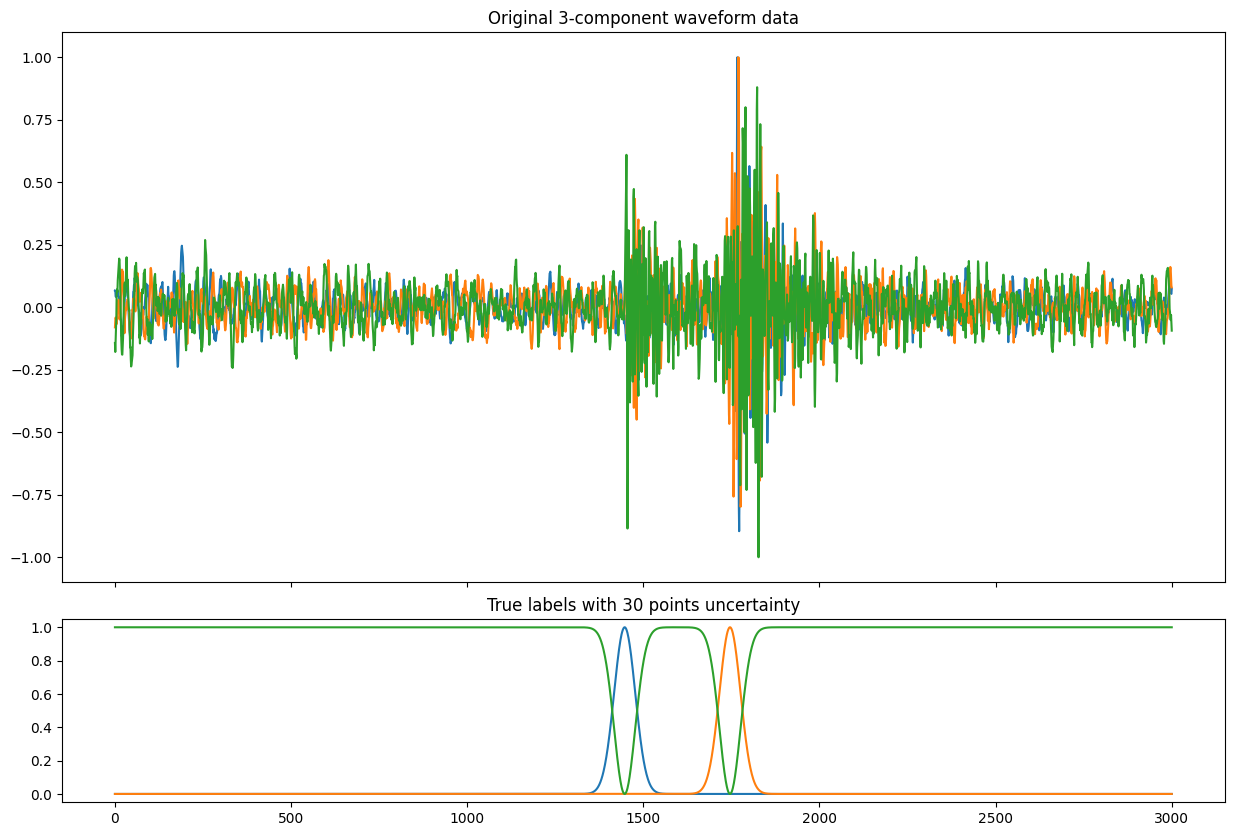

In [362]:
train_generator_after = sbg.GenericGenerator(train_dataset_after)
val_generator_after = sbg.GenericGenerator(val_dataset_after)
test_generator_after = sbg.GenericGenerator(test_dataset_after)

# Note: The windowlen must be larger than 3000 for the PhaseNet model !!!
samples_before = 3000  # 0.1s
windowlen = 6000

# Define the augmentations
augmentations = [
    # First, slice the data roughly around the picks
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=samples_before, windowlen=windowlen, 
                           selection="random", strategy="variable"),
    # Secondly, slide to get several 3001 samples (overlapping is normal), which are the real input data (length)!
    # That's the length of the below images. This is a necessary step which can generate more data.
    sbg.RandomWindow(windowlen=3001, strategy="pad"),  
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

# Add the augmentations to the generators
train_generator_after.add_augmentations(augmentations)
val_generator_after.add_augmentations(augmentations)
test_generator_after.add_augmentations(augmentations)

# Visualize the augmentations
# Note for the 'y' plot which are related to labels: P, S, Noise (1-P-S) 
# Blue: P, Orange: S, Green: Noise
sample_after = train_generator_after[752]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0.1, "height_ratios": [3, 1]})
axs[0].plot(sample_after["X"].T)  # np.array (3, 4000)
axs[0].set_title("Original 3-component waveform data")
axs[1].plot(sample_after["y"].T)  # np.array (3, 4000)
axs[1].set_title("True labels with 30 points uncertainty")

## 5. Train the model

Group 1 dataset: 8:1:1
- train_generator_before  ---> train_loader_before
- val_generator_before    ---> val_loader_before
- test_generator_before   ---> test_loader_before

Group 2 dataset: 8:1:1
- train_generator_after   ---> train_loader_after
- val_generator_after     ---> val_loader_after
- test_generator_after    ---> test_loader_after

#### 5.1 Load the PhaseNet model: we need 2!

In [332]:
sbm.PhaseNet.list_pretrained()   

['diting',
 'ethz',
 'geofon',
 'instance',
 'iquique',
 'lendb',
 'neic',
 'obs',
 'original',
 'scedc',
 'stead']

In [233]:
device = torch.device("cpu")
model_before = sbm.PhaseNet(phases="PSN", norm="peak")
model_before.to(device)

model_after = sbm.PhaseNet(phases="PSN", norm="peak")
model_after.to(device)

# Only display one cuz they are the same
# Print the model's structure
print(model_before)
# Print the number of parameters
total_params = sum(p.numel() for p in model_before.parameters())
trainable_params = sum(p.numel() for p in model_before.parameters() if p.requires_grad)
print("\nTotal number of parameters: ", total_params)
print("Total number of trainable parameters: ", trainable_params)

Component order:	ZNE
SeisBench model		PhaseNet

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      

#### 5.2 Load the dataset

In [234]:
batch_size = 256
num_workers = 4

# Group 1 dataset: before filtering
train_loader_before = DataLoader(train_generator_before, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
val_loader_before = DataLoader(val_generator_before, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader_before = DataLoader(test_generator_before, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

# Group 2 dataset: after filtering
train_loader_after = DataLoader(train_generator_after, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
val_loader_after = DataLoader(val_generator_after, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader_after = DataLoader(test_generator_after, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

#### 5.3 Define necessary parameters and public functions

In [235]:
learning_rate = 1e-4
epochs = 60

# Define the loss function
def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

def train_loop(dataloader, model, optimizer, history):
    # Initialize parameters
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute the total loss
        total_loss += loss.item()

        # Print the loss every 5 batches
        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Save the average loss of each epoch: because we have several groups (and corresponding losses) in each epoch.
    avg_loss = total_loss / num_batches
    history["train_loss"].append(avg_loss)


def test_loop(dataloader, model, history):
    # Initialize parameters
    num_batches = len(dataloader)
    test_loss = 0
    # close the model for evaluation
    model.eval()  

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    # re-open model for training stage
    model.train()  

    test_loss /= num_batches
    history["test_loss"].append(test_loss)
    print(f"Test avg loss: {test_loss:>8f} \n")

In [236]:
# Define the plot function
def plot_history(history, filename="loss_train_val.png"):
    # Define x-axis: epochs
    epochs = range(1, len(history["train_loss"]) + 1)
    
    # Loss curves
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history["train_loss"], 'bo-', label='Training loss')
    plt.plot(epochs, history["test_loss"], 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plot
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

#### 5.4 Train the model using two groups of datasets, and save the trained models!

##### Group 1: before filtering

Group 1: before filtering
Epoch 1
-------------------------------
loss: 1.717329  [    0/89468]
loss: 1.683053  [ 1280/89468]
loss: 1.648636  [ 2560/89468]
loss: 1.603633  [ 3840/89468]
loss: 1.568343  [ 5120/89468]
loss: 1.533036  [ 6400/89468]
loss: 1.505325  [ 7680/89468]
loss: 1.480387  [ 8960/89468]
loss: 1.453328  [10240/89468]
loss: 1.428500  [11520/89468]
loss: 1.398448  [12800/89468]
loss: 1.385198  [14080/89468]
loss: 1.355124  [15360/89468]
loss: 1.336350  [16640/89468]
loss: 1.317993  [17920/89468]
loss: 1.291735  [19200/89468]
loss: 1.270958  [20480/89468]
loss: 1.267850  [21760/89468]
loss: 1.252181  [23040/89468]
loss: 1.264021  [24320/89468]
loss: 1.232654  [25600/89468]
loss: 1.231718  [26880/89468]
loss: 1.209165  [28160/89468]
loss: 1.204699  [29440/89468]
loss: 1.201788  [30720/89468]
loss: 1.193517  [32000/89468]
loss: 1.194158  [33280/89468]
loss: 1.182835  [34560/89468]
loss: 1.175533  [35840/89468]
loss: 1.170144  [37120/89468]
loss: 1.169167  [38400/89468]
loss

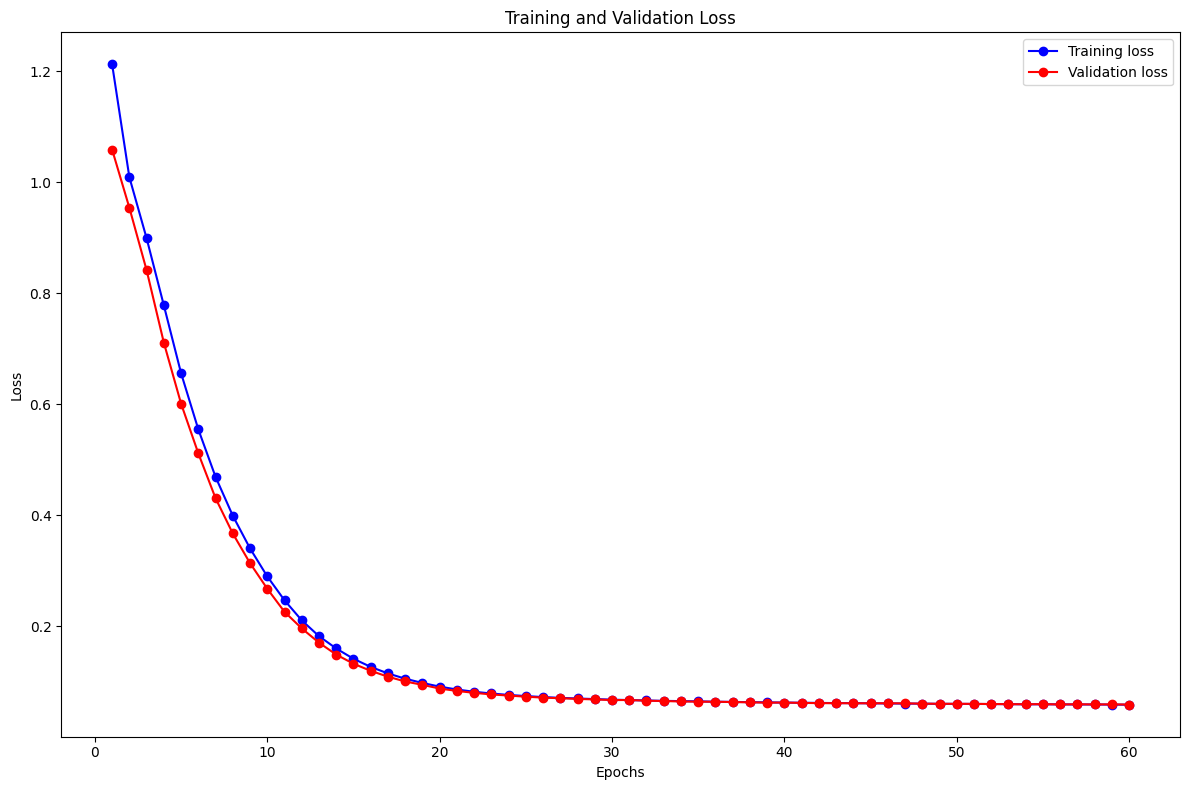

Model is saved successfully!


In [237]:
history_before = {
    "train_loss": [],
    "test_loss": []
}
# Define the optimizer
optimizer_before = torch.optim.Adam(model_before.parameters(), lr=learning_rate)
# Train
print("Group 1: before filtering")
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader=train_loader_before, model=model_before, optimizer=optimizer_before, history=history_before)
    test_loop(dataloader=val_loader_before, model=model_before, history=history_before)
end_time = time.time()
print(f"Total Training time for {epochs} Epoches: {end_time - start_time}s")
# Visualize the training and validation loss
plot_history(history_before, filename=f"{epochs}epochs_loss_train_test_before_filtering.png")

# Save the trained model
model_base_dir = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/"
current_model_name = f"{epochs}epochs_model_before_filtering.pt"
saved_model_path = os.path.join(model_base_dir, current_model_name)
torch.save(model_before.state_dict(), saved_model_path)  # The saved file suffix must be '.pt'
print("Model is saved successfully!")

##### Group 2: after filtering

Group 2: after filtering
Epoch 1
-------------------------------
loss: 1.646623  [    0/89468]
loss: 1.630478  [ 1280/89468]
loss: 1.612463  [ 2560/89468]
loss: 1.604837  [ 3840/89468]
loss: 1.580459  [ 5120/89468]
loss: 1.569414  [ 6400/89468]
loss: 1.562745  [ 7680/89468]
loss: 1.553786  [ 8960/89468]
loss: 1.535049  [10240/89468]
loss: 1.531553  [11520/89468]
loss: 1.514425  [12800/89468]
loss: 1.508072  [14080/89468]
loss: 1.492527  [15360/89468]
loss: 1.479864  [16640/89468]
loss: 1.471188  [17920/89468]
loss: 1.449730  [19200/89468]
loss: 1.455932  [20480/89468]
loss: 1.447328  [21760/89468]
loss: 1.435440  [23040/89468]
loss: 1.430599  [24320/89468]
loss: 1.432524  [25600/89468]
loss: 1.416149  [26880/89468]
loss: 1.411804  [28160/89468]
loss: 1.412371  [29440/89468]
loss: 1.416395  [30720/89468]
loss: 1.398772  [32000/89468]
loss: 1.393166  [33280/89468]
loss: 1.392273  [34560/89468]
loss: 1.390396  [35840/89468]
loss: 1.386546  [37120/89468]
loss: 1.383966  [38400/89468]
loss:

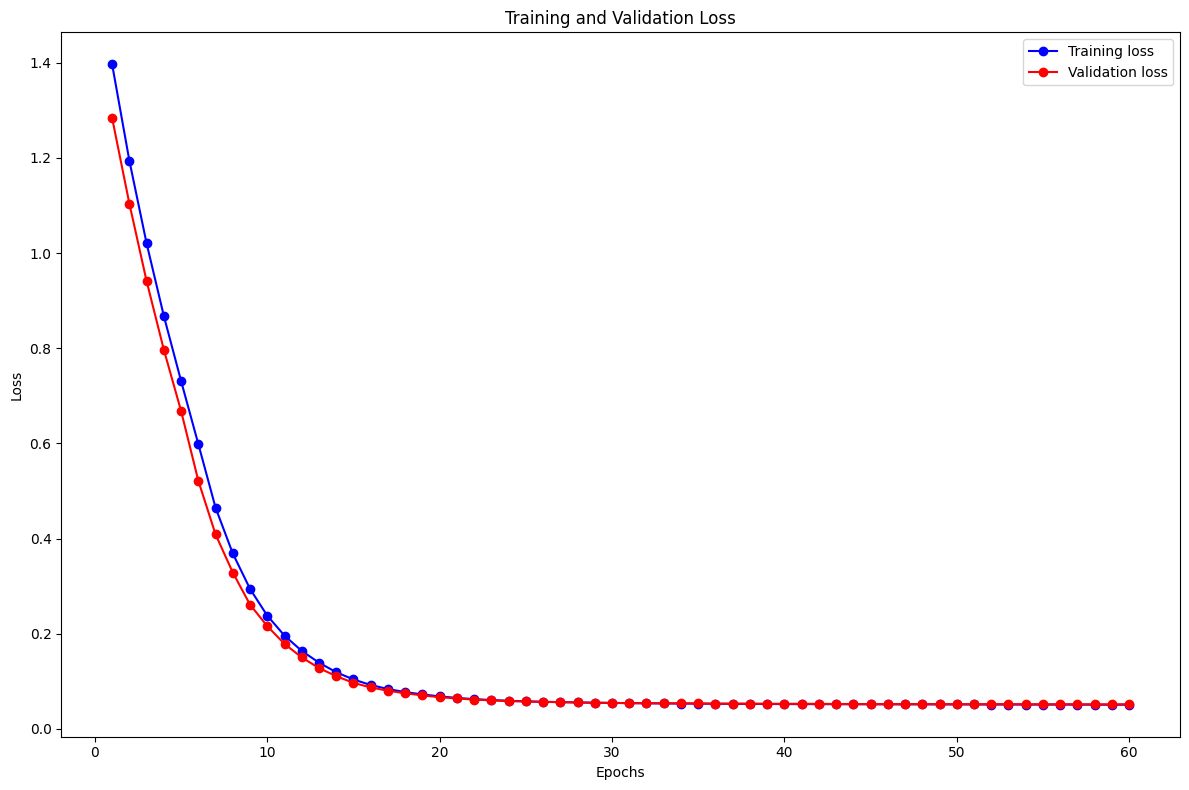

Model is saved successfully!


In [238]:
history_after = {
    "train_loss": [],
    "test_loss": []
}
# Define the optimizer
optimizer_after = torch.optim.Adam(model_after.parameters(), lr=learning_rate)
# Train
print("Group 2: after filtering")
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader=train_loader_after, model=model_after, optimizer=optimizer_after, history=history_after)
    test_loop(dataloader=val_loader_after, model=model_after, history=history_after)
end_time = time.time()
print(f"Total Training time for {epochs} Epoches: {end_time - start_time}s")
# Visualize the training and validation loss
plot_history(history_after, filename=f"{epochs}epochs_loss_train_test_after_filtering.png")

# Save the trained model
model_base_dir = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/"
current_model_name = f"{epochs}epochs_model_after_highpass.pt"
saved_model_path = os.path.join(model_base_dir, current_model_name)
torch.save(model_after.state_dict(), saved_model_path)  # The saved file suffix must be '.pt'
print("Model is saved successfully!")

In [342]:
type(val_generator_after), type(val_loader_after), type(val_dataset_after), type(train_dataset_base_path_before)

(seisbench.generate.generator.GenericGenerator,
 torch.utils.data.dataloader.DataLoader,
 seisbench.data.base.WaveformDataset,
 str)

In [340]:
picks_before = model_before.classify(val_dataset_before)

AttributeError: 'WaveformDataset' object has no attribute 'merge'

In [ ]:
_

## 6. Model Evaluation (Don't use this part)

Text(0.5, 1.0, 'Predicted labels (P, S, Noise)')

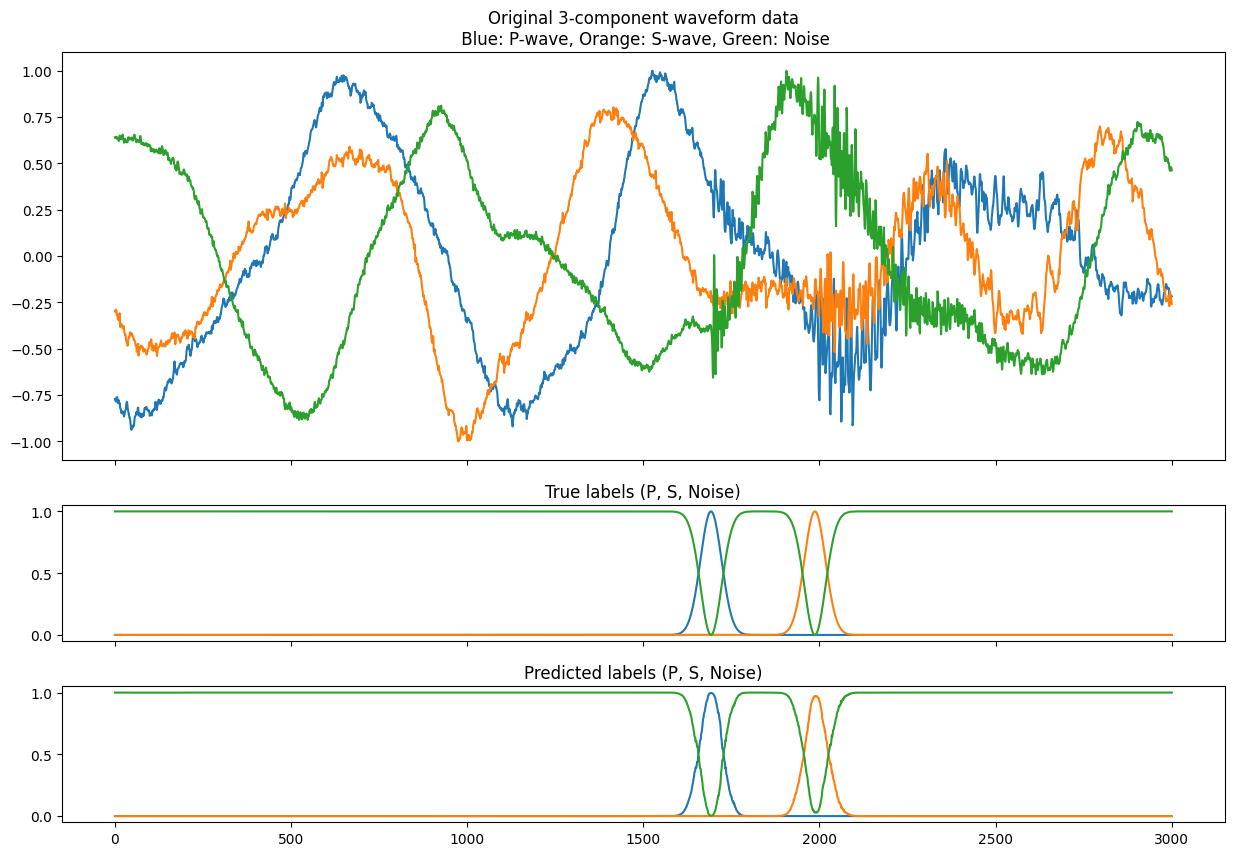

In [295]:
sample_before = val_generator_before[2]

fig = plt.figure(figsize=(15, 10))
# Note: "hspace" is the amount of height reserved for space between subplots
axs = fig.subplots(3, 1, sharex=True, 
                   gridspec_kw={"hspace": 0.2, "height_ratios": [3, 1, 1]})
axs[0].plot(sample_before["X"].T)
axs[0].set_title("Original 3-component waveform data\n Blue: P-wave, Orange: S-wave, Green: Noise")
axs[1].plot(sample_before["y"].T)
axs[1].set_title("True labels (P, S, Noise)")

# Predict the labels
model_before.eval()  # close the model for evaluation
with torch.no_grad():
    pred = model_before(torch.tensor(sample_before["X"], device=model_before.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)
axs[2].set_title("Predicted labels (P, S, Noise)")

Text(0.5, 1.0, 'Predicted labels (P, S, Noise)')

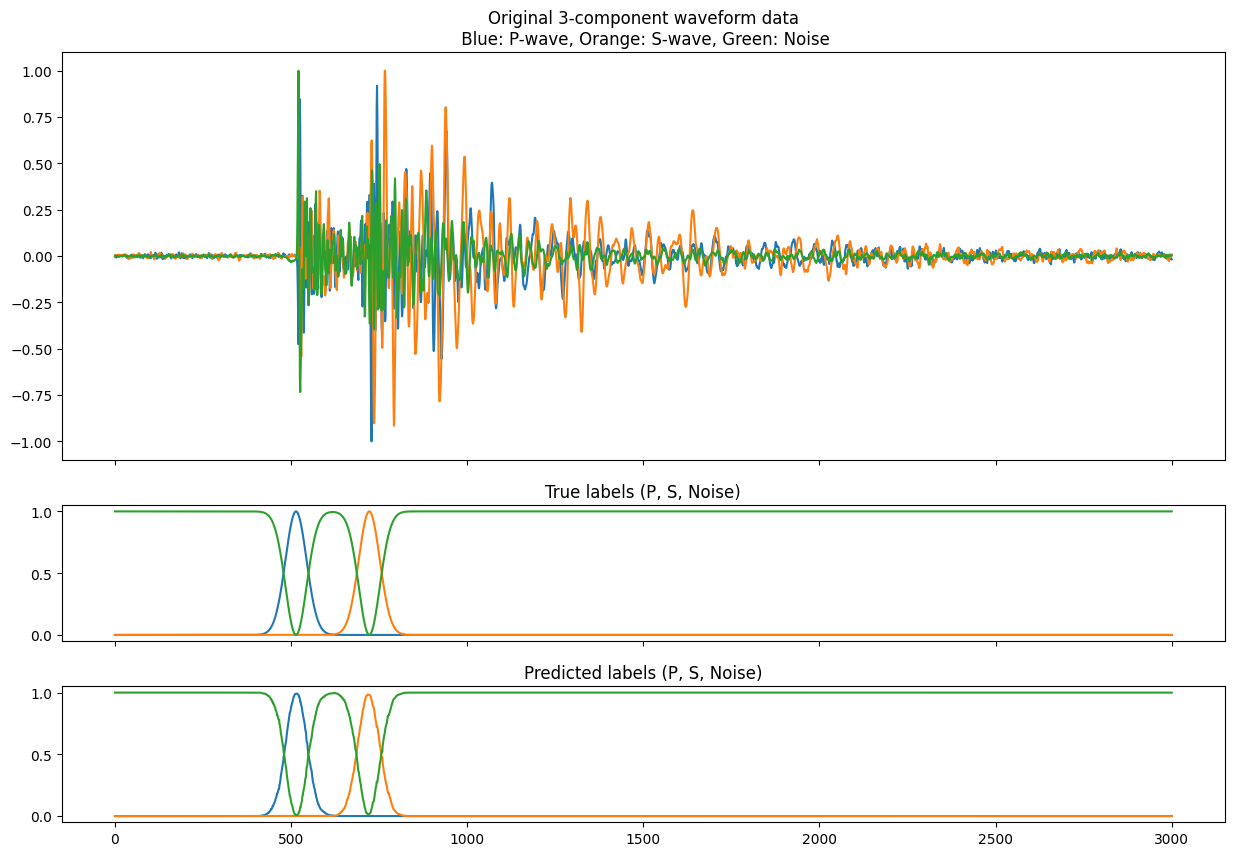

In [363]:
sample_after = val_generator_after[5]

fig = plt.figure(figsize=(15, 10))
# Note: "hspace" is the amount of height reserved for space between subplots
axs = fig.subplots(3, 1, sharex=True, 
                   gridspec_kw={"hspace": 0.2, "height_ratios": [3, 1, 1]})
axs[0].plot(sample_after["X"].T)
axs[0].set_title("Original 3-component waveform data\n Blue: P-wave, Orange: S-wave, Green: Noise")
axs[1].plot(sample_after["y"].T)
axs[1].set_title("True labels (P, S, Noise)")

# Predict the labels
model_after.eval()  # close the model for evaluation
with torch.no_grad():
    pred = model_after(torch.tensor(sample_after["X"], device=model_after.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)
axs[2].set_title("Predicted labels (P, S, Noise)")

In [313]:
len(val_generator_after[0]['X'][0])

3001

## 7. Model Evaluation (original stream data)

In [324]:
# Original files: no filtering
original_waveform_dir_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_before_filtering"
stream_test = get_random_stream_file(original_waveform_dir_path)
print(stream_test)

3 Trace(s) in Stream:
OR.INNST.00.HHE | 2019-04-01T13:12:55.929999Z - 2019-04-01T13:14:15.929999Z | 200.0 Hz, 16001 samples
OR.INNST.00.HHN | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 200.0 Hz, 16001 samples
OR.INNST.00.HHZ | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 200.0 Hz, 16001 samples


##### 7.1 model_before prediction

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


/tmp/ipykernel_639029/2604057564.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


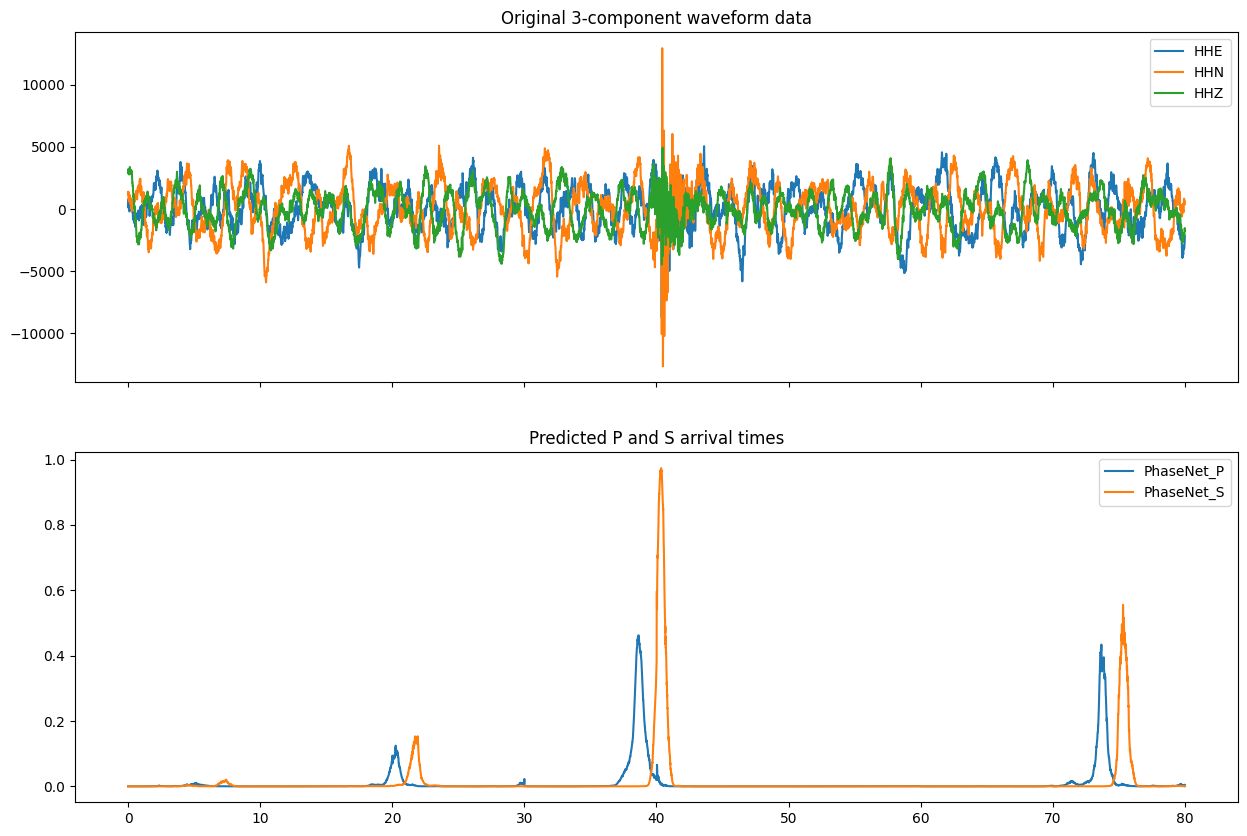

In [331]:
# Annotate the stream file using the trained model 
annotations_before = model_before.annotate(stream_test, overlap=2000)
print(annotations_before)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_before[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if annotations_before[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_before[i].times() + offset, annotations_before[i].data, label=annotations_before[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times")

plt.tight_layout()
plt.savefig("Validation_on_Newdata", dpi=300, bbox_inches='tight')
plt.show()

##### 7.2 model_after prediction: before filtering

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


Text(0.5, 1.0, 'Predicted P and S arrival times')

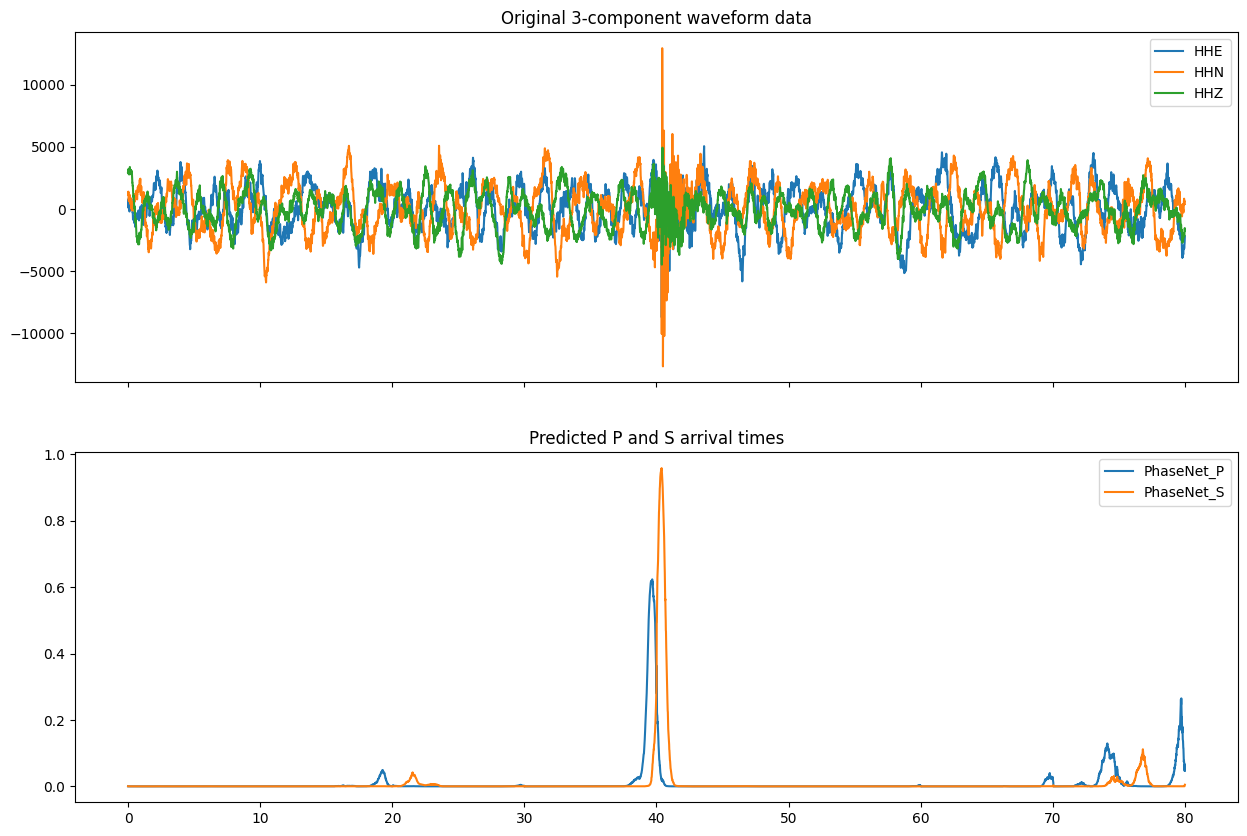

In [333]:
annotations_after1 = model_after.annotate(stream_test, overlap=2000)
print(annotations_after1)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_after1[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if annotations_after1[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_after1[i].times() + offset, annotations_after1[i].data, label=annotations_after1[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times")

##### 7.3 model_after prediction: after filtering

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


Text(0.5, 1.0, 'Predicted P and S arrival times')

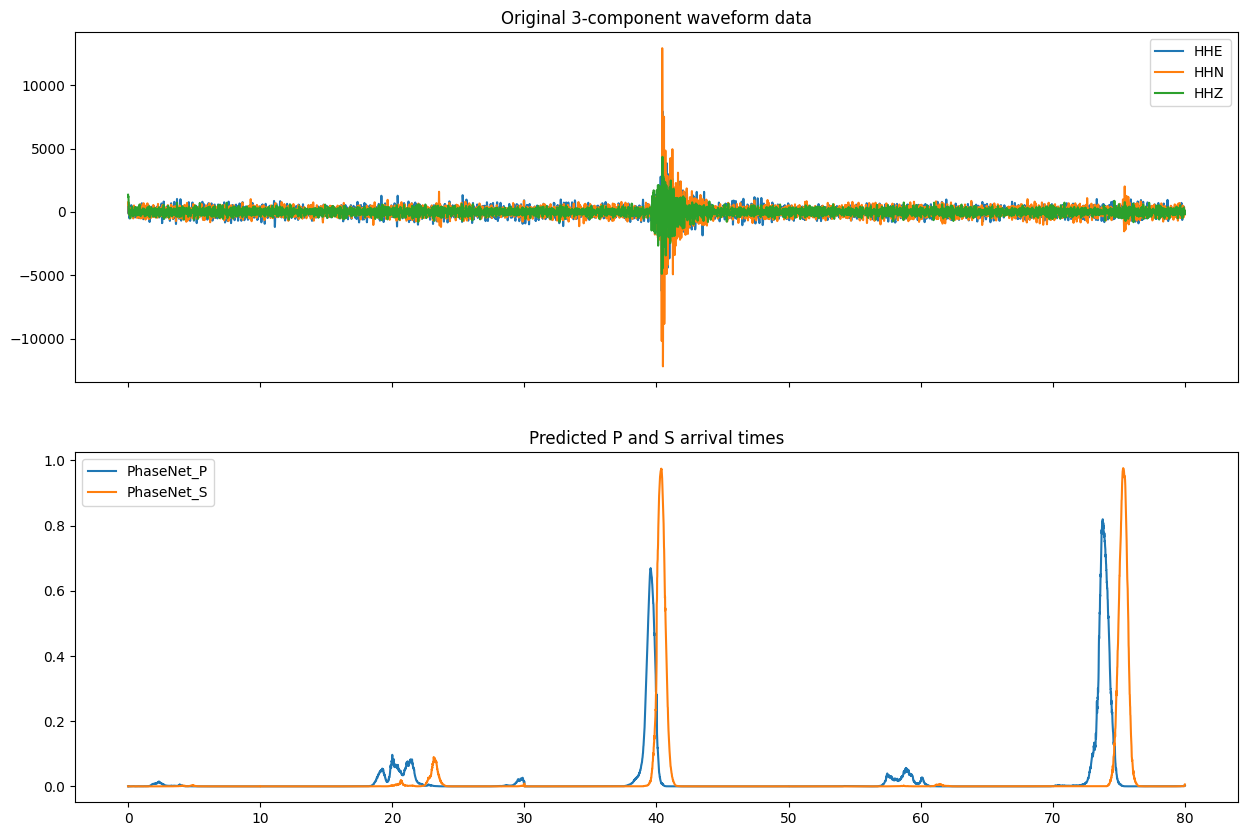

In [329]:
stream_test_filtered = apply_highpass(stream_test, freq=3)
annotations_after2 = model_after.annotate(stream_test_filtered, overlap=2000)
# picks = model_after.classify(stream_test_filtered)   Test here.
print(annotations_after2)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_after2[0].stats.starttime - stream_test_filtered[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test_filtered[i].times(), 
                stream_test_filtered[i].data, 
                label=stream_test_filtered[i].stats.channel)
    if annotations_after2[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_after2[i].times() + offset, 
                    annotations_after2[i].data, 
                    label=annotations_after2[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times")

### 8. Test validation using different models

#### 8.1 Load all models 

In [366]:
# 1) Original model before filtering
original_model_before_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/60epochs_model_before_filtering.pt"
orginal_model_before = sbm.PhaseNet(phases="PSN", norm="peak")
orginal_model_before.load_state_dict(torch.load(original_model_before_path))

# 2) Original model after filtering
original_model_after_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/60epochs_model_after_highpass.pt"
orginal_model_after = sbm.PhaseNet(phases="PSN", norm="peak")
orginal_model_after.load_state_dict(torch.load(original_model_after_path))

# 3) Pre-trained model before filtering
pretrained_model_before_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/pre_60epochs_model_before_filtering.pt"
pretrained_model_before = sbm.PhaseNet(phases="PSN", norm="peak")
pretrained_model_before.load_state_dict(torch.load(pretrained_model_before_path))

# 4) Pre-trained model after filtering
pretrained_model_after_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/pre_60epochs_model_after_highpass.pt"
pretrained_model_after = sbm.PhaseNet(phases="PSN", norm="peak")
pretrained_model_after.load_state_dict(torch.load(pretrained_model_after_path))

print("4 Models loaded successfully.")

############ Base model ############
base_model = sbm.PhaseNet.from_pretrained("original")

print("Base model loaded successfully.")

4 Models loaded successfully.
Base model loaded successfully.


#### 8.2 Load the corresponding test stream data for each model

In [539]:
original_waveform_dir_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_before_filtering"
stream_before = get_random_stream_file(original_waveform_dir_path_before)

##### Model 1: Original model before filtering

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


Text(0, 0.5, 'Probability')

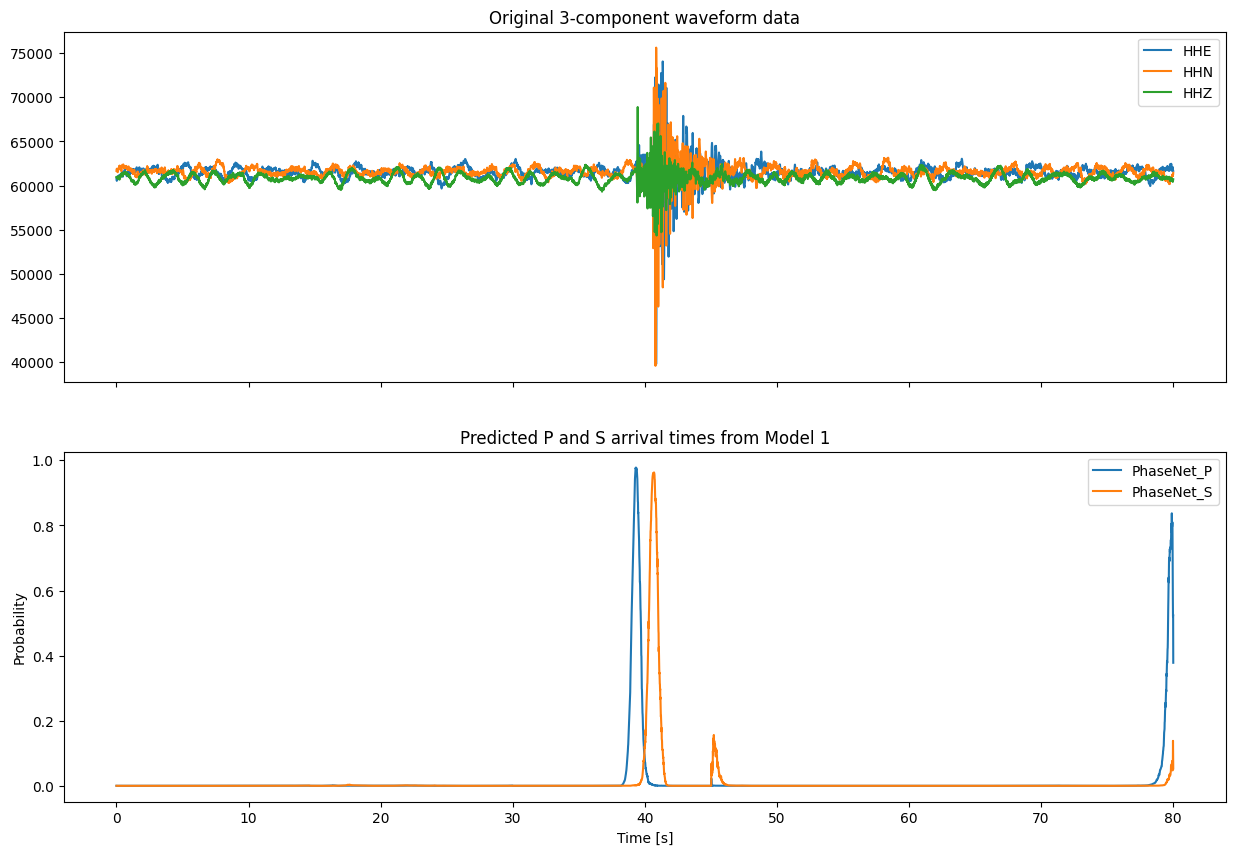

In [540]:
model = orginal_model_before
stream_test = stream_before
annotations_after = model.annotate(stream_test)
print(annotations_after1)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_after[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if annotations_after[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_after[i].times() + offset, annotations_after[i].data, label=annotations_after[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times from Model 1")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Probability")

##### Model 3: Pretrained model before filtering

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


Text(0, 0.5, 'Probability')

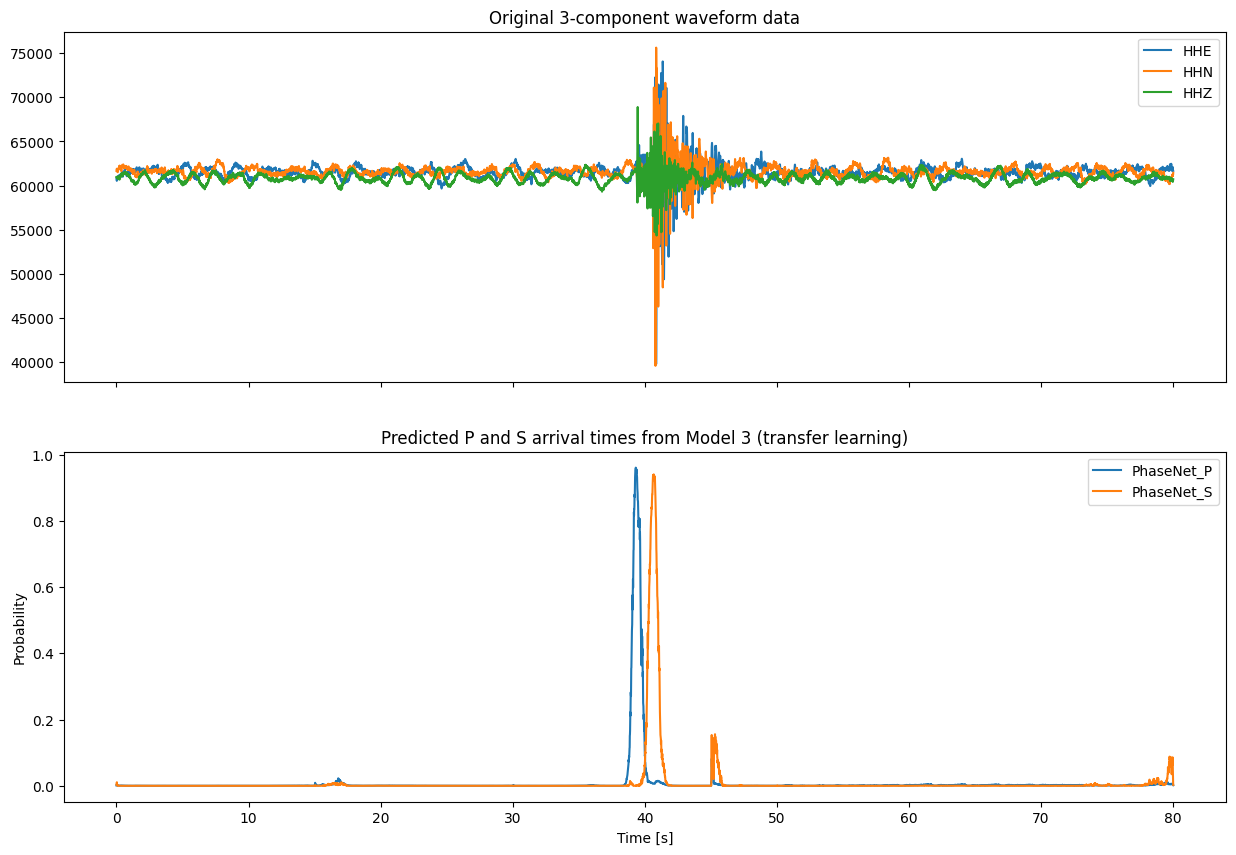

In [541]:
model = pretrained_model_before
stream_test = stream_before
annotations_after = model.annotate(stream_test)
print(annotations_after1)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_after[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if annotations_after[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_after[i].times() + offset, annotations_after[i].data, label=annotations_after[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times from Model 3 (transfer learning)")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Probability")

##### Model 5: Base model evaluation on dataset before filtering

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


Text(0, 0.5, 'Probability')

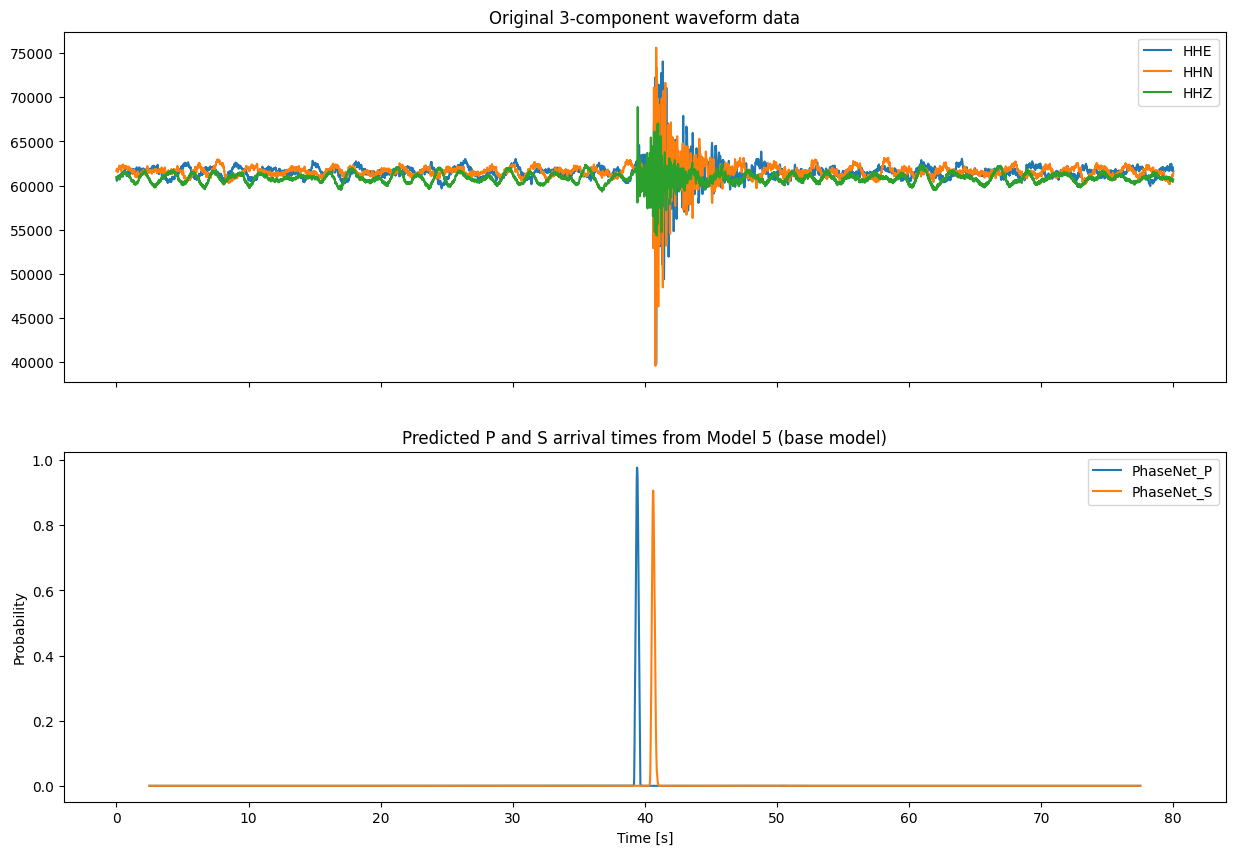

In [542]:
model = base_model
stream_test = stream_before
annotations_after = model.annotate(stream_test)
print(annotations_after1)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_after[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if annotations_after[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_after[i].times() + offset, annotations_after[i].data, label=annotations_after[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times from Model 5 (base model)")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Probability")

##### Model 2: Original model after filtering

In [543]:
stream_after = apply_highpass(stream_before, freq=3)

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


Text(0, 0.5, 'Probability')

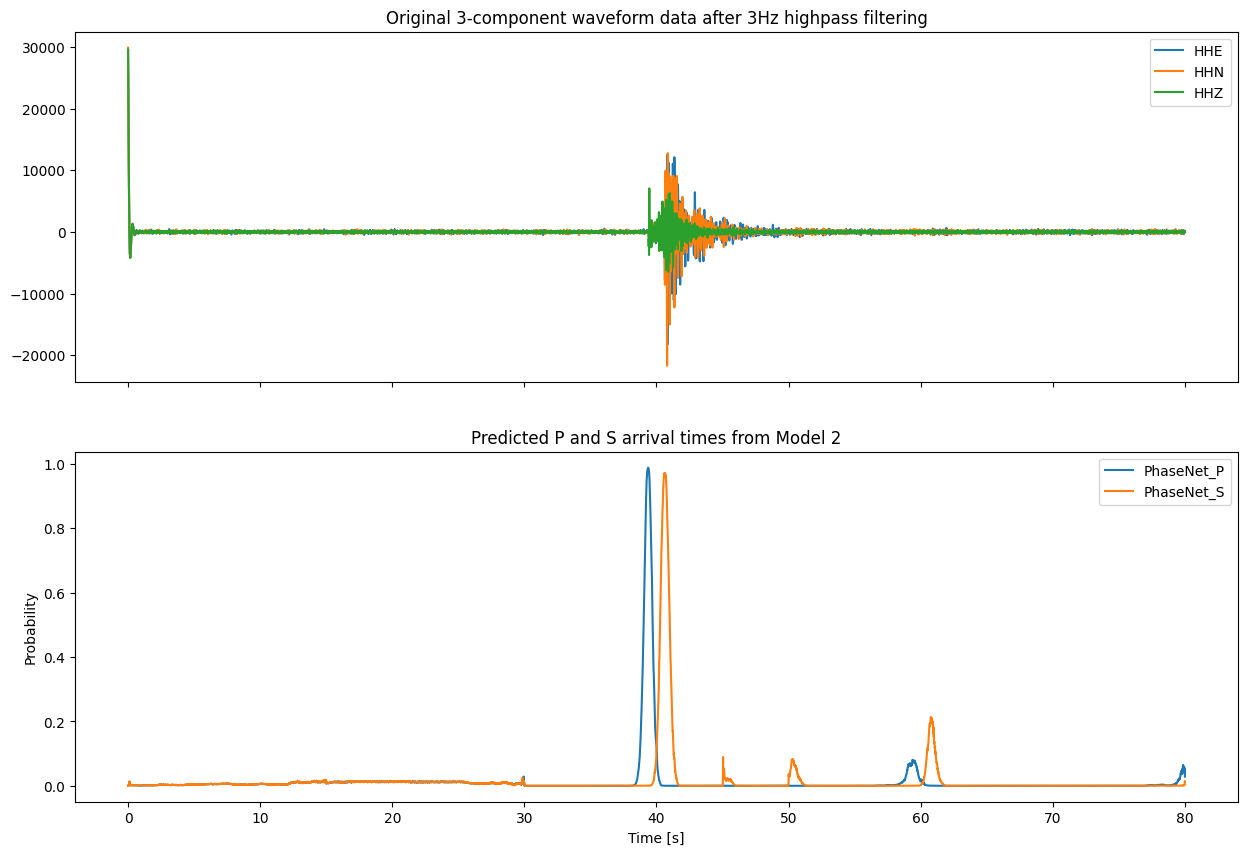

In [544]:
model = orginal_model_after
stream_test = stream_after
annotations_after = model.annotate(stream_test)
print(annotations_after1)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_after[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if annotations_after[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_after[i].times() + offset, annotations_after[i].data, label=annotations_after[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data after 3Hz highpass filtering")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times from Model 2")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Probability")

##### Model 4: Pretrained model after filtering

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


Text(0, 0.5, 'Probability')

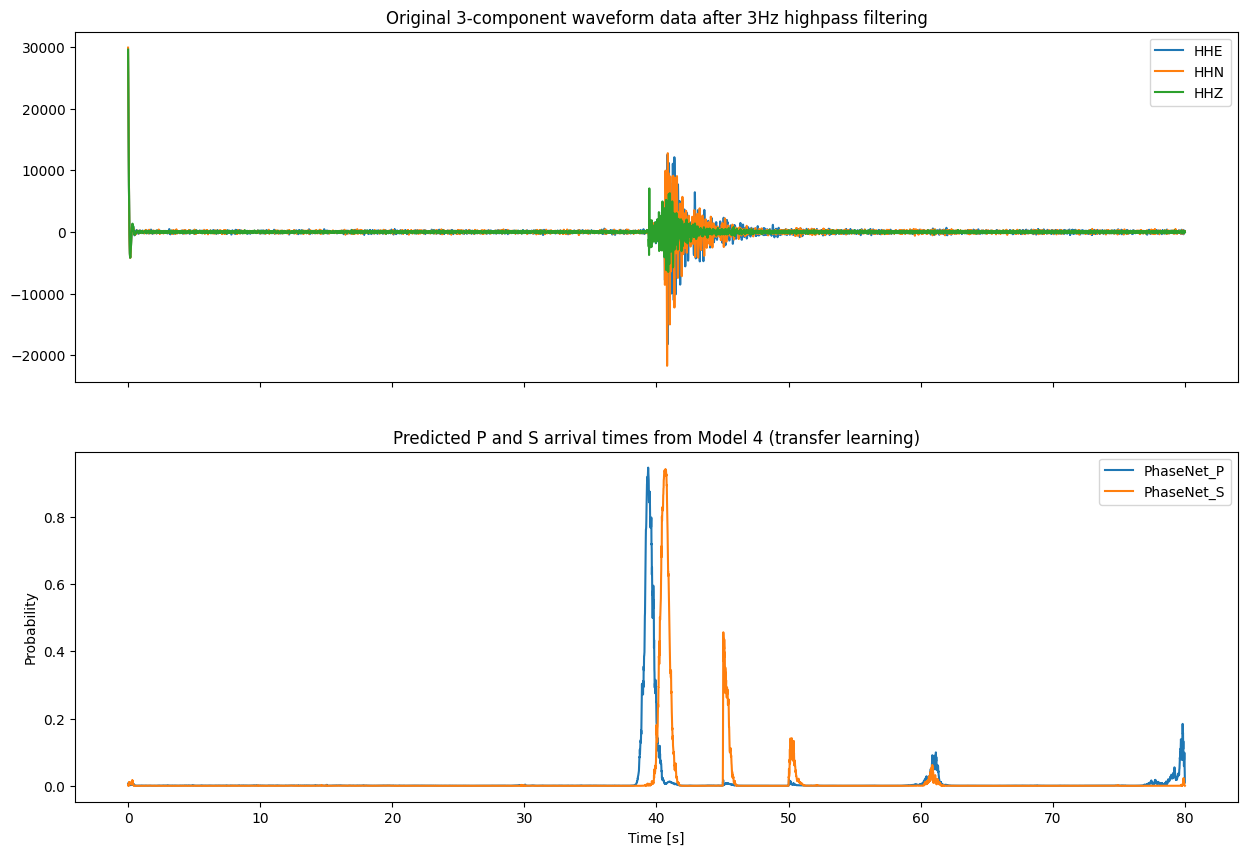

In [545]:
model = pretrained_model_after
stream_test = stream_after
annotations_after = model.annotate(stream_test)
print(annotations_after1)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_after[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if annotations_after[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_after[i].times() + offset, annotations_after[i].data, label=annotations_after[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data after 3Hz highpass filtering")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times from Model 4 (transfer learning)")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Probability")

##### Model 5: Base model evaluation on dataset after filtering

3 Trace(s) in Stream:
OR.INNST.00.PhaseNet_P | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_S | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples
OR.INNST.00.PhaseNet_N | 2019-04-01T13:12:55.930000Z - 2019-04-01T13:14:15.930000Z | 100.0 Hz, 8001 samples


Text(0, 0.5, 'Probability')

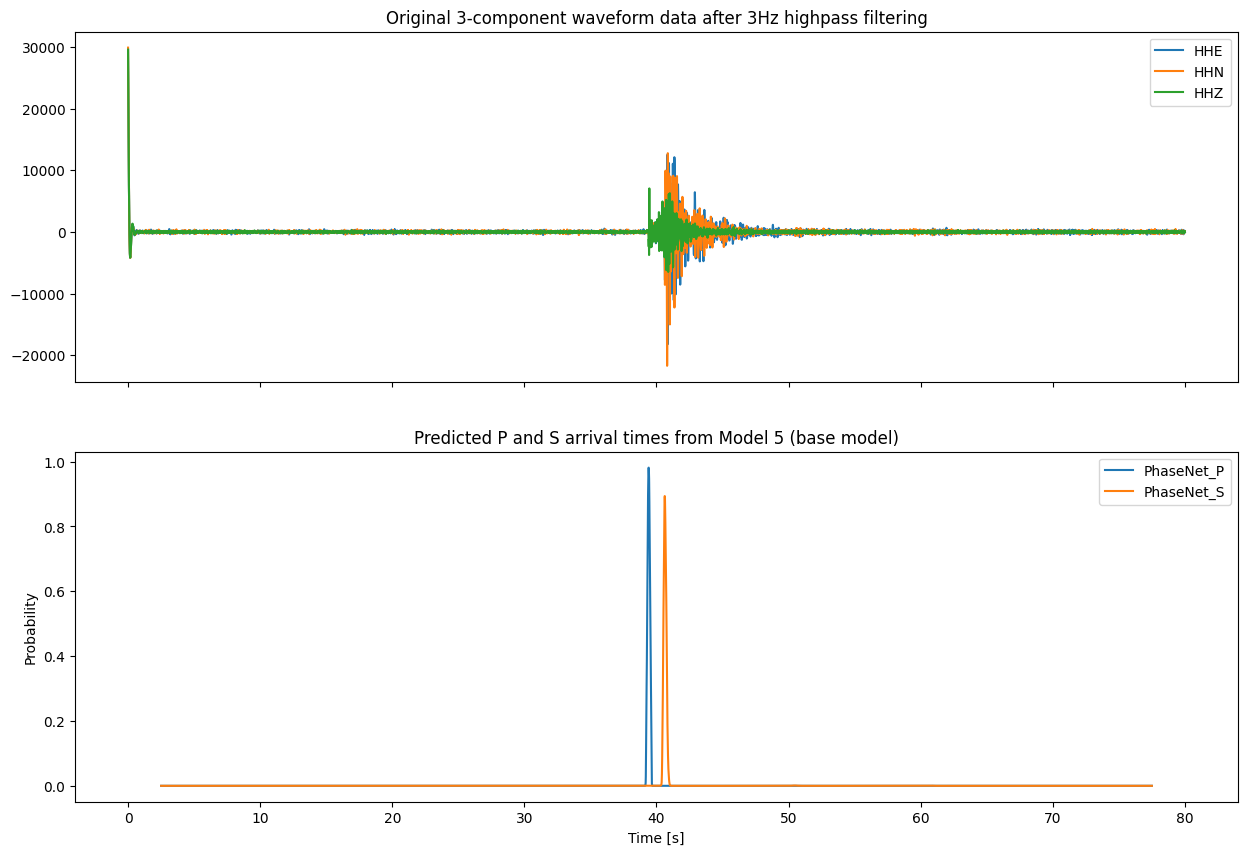

In [546]:
model = base_model
stream_test = stream_after
annotations_after = model.annotate(stream_test)
print(annotations_after1)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = annotations_after[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if annotations_after[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(annotations_after[i].times() + offset, annotations_after[i].data, label=annotations_after[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data after 3Hz highpass filtering")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times from Model 5 (base model)")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Probability")